# AP-1 FDR Analysis

## Imports

In [ ]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import matplotlib_venn
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('talk')

In [ ]:
workingDirectory = '/home/jtao/analysis/ap1_fdr_analysis/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)
peakDirectory = '/home/jtao/analysis/ap1_fdr_analysis/peak_files/'
tagDirPath = '/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1/'

In [ ]:
# file directories

os.chdir(workingDirectory)

# read in and parse name mapping file and create a DataFrame representation

strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
sampleNames = []

for sample in sorted(os.listdir(tagDirPath)):
    metaDataTokens = sample.strip().split("_")
    
    sampleNames.append(sample)
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_tagsPerPosition = []
for sample in [x for x in sorted(os.listdir(tagDirPath)) if not 'nput' in x and not 'p65' in x and not 'cebp' in x]:
    logFile = [x for x in os.listdir(tagDirPath + '/' + sample) if '.log'in x][0] # find mapping log file
    
    with open(tagDirPath + '/' + sample + '/' + logFile) as f:
        data = f.readlines()
            
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _sampleNames.append(sample)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        tpp = float(data[5].strip().split('=')[1])
        _tagsPerPosition.append(tpp)
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']



summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

In [ ]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 1000000

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['mappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] 
                            + '_' + filtered_summary_frame['factor'] 
                            + '_' + filtered_summary_frame["simpleTreatment"]
                            + '_' + filtered_summary_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_frame['sampleName'].values,
                                       filtered_summary_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_frame['simplifiedName'].values,
                                       filtered_summary_frame['sampleName'].values))

## Peak Calling

In [ ]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile = open('./peakCalling_homer.sh', 'w')


for tagDir in filtered_summary_frame['sampleName'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]

    peakFileName = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

    if "veh" in treatment.lower():
        inputDir = '/home/jtao/analysis/ap1_analysis/input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20'
    elif "kla" in treatment.lower():
        inputDir = '/home/jtao/analysis/ap1_analysis/input_data/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20'
    
    scriptFile.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                 ' -i ' + inputDir
                 + ' -style factor -size 200 -norm 1e6 > ' + 
                 peakDirectory +'/' + peakFileName + ' &\n')
scriptFile.close()

In [ ]:
%%bash
rm ./peak_files/*
chmod a+x ./*sh
bash ./peakCalling_homer.sh

## Copy IDR Peak files

In [ ]:
%%bash
if [ ! -d ./idr_peak_files ]; then mkdir ./idr_peak_files; else rm ./idr_peak_files/*; fi
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_files/c57bl6* ./idr_peak_files/
rm ./idr_peak_files/*p65*
rm ./idr_peak_files/*cebp*
for i in ./idr_peak_files/*;
    do mv $i ${i/_peaks.tsv/_idr_peaks.tsv};
done

## Peak Filtering

In [ ]:
# filter away peaks that have less than 16 normalized tags
# rename peak files to remove redundant information
chroms = ['chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chrX']
seen_conditions = set()
peakDirectory = './peak_files/'
filtered_peak_directory = './filtered_peak_files/'
if not os.path.isdir(filtered_peak_directory):
    os.mkdir(filtered_peak_directory)
for f in os.listdir(peakDirectory):
    print(f)
    tokens = f.split('_')
    condition = tokens[0] +'_'+ tokens[1] + '_' + tokens[2]
    
    if condition in seen_conditions:
        new_name = filtered_peak_directory+'/'+condition + '_rep2_peaks.tsv' 
    else:
        new_name = filtered_peak_directory+'/'+condition + '_rep1_peaks.tsv' 
        seen_conditions.add(condition)
    current_frame = pd.read_csv(peakDirectory + '/' + f, sep = '\t', skiprows=39)
    filtered_frame = current_frame[(current_frame['chr'].isin(chroms)) &
                                  (current_frame['Normalized Tag Count'] >= 1)]
    filtered_frame.to_csv(new_name, sep='\t', index=False)

In [ ]:
# filter away peaks that have less than 16 normalized tags
# rename peak files to remove redundant information
chroms = ['chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chrX']
seen_conditions = set()
filtered_peak_directory = './filtered_idr_peak_files/'
if not os.path.isdir(filtered_peak_directory):
    os.mkdir(filtered_peak_directory)
peakDirectory = './idr_peak_files/'
for f in os.listdir(peakDirectory):
    print(f)
    tokens = f.split('_')
    condition = tokens[0] +'_'+ tokens[1] + '_' + tokens[2]
    new_name = filtered_peak_directory+'/'+condition + '_idr_peaks.tsv' 
    current_frame = pd.read_csv(peakDirectory + '/' + f, sep = '\t')
    filtered_frame = current_frame[current_frame['chr'].isin(chroms)]
    filtered_frame.to_csv(new_name, sep='\t', index=False)

## Merge Peaks

In [101]:
%%capture
%%bash
mergePeaks -d 100 ./filtered_idr_peak_files/*tsv ./filtered_peak_files/*tsv > merged_peaks.tsv

makeSummaryFile.py ./merged_peaks.tsv ./group_summary.tsv ./filtered_peak_files/*tsv ./filtered_idr_peak_files/*tsv

## Annotate Peaks

In [104]:
%%bash
annotatePeaks.pl ./merged_peaks.tsv mm10 -d /home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1/*/ > annotated_peaks.tsv

Process is interrupted.


## Convert to BED Files

In [ ]:
%%bash
# individual replicates
if [ ! -d ./bed_files ]; then mkdir ./bed_files/; else rm ./bed_files/*; fi

for i in ./filtered_peak_files/*tsv;
    do echo $i;
    outpath=./bed_files/${i##*/}
    outpath=${outpath/_peaks.tsv/.bed}
    echo $outpath
    pos2bed.pl $i > ./tmp
    tail -n +2 ./tmp > $outpath
done

# idr peaks
for i in ./filtered_idr_peak_files/*tsv;
    do echo $i;
    outpath=./bed_files/${i##*/}
    outpath=${outpath/_peaks.tsv/.bed}
    echo $outpath
    pos2bed.pl $i > ./tmp
    tail -n +2 ./tmp > $outpath
done
rm tmp



## Extract Sequences

In [ ]:
%%bash
if [ ! -d ./fasta_files ]; then mkdir ./fasta_files/; else rm ./fasta_files/*; fi

for i in ./bed_files/*bed; 
    do echo $i;
    outpath=./fasta_files/${i##*/}
    outpath=${outpath/.bed/.fasta}
    /gpfs/data01/glasslab/home/jtao/code/tba/extract_sequences.py $i mm10 $outpath
done

## Construct Background

In [ ]:
%%bash
rm ./make_background.sh
script_path="./make_background.sh"
if [ ! -d ./background/ ]; then mkdir ./background/ ; fi
for i in ./bed_files/*bed;
do 
    factor=${i##*/};
    factor=${factor%.bed};

    fasta_path="./background/${factor}_background.fasta"
    bed_path="./background/${factor}_background.bed"
    if [ ! -f $fasta_path ];
    then
    echo "/home/jtao/code/tba/generate_background_coordinates.py $i ./background/ -genome mm10";
    echo "mv ./background/background.bed $bed_path";
    echo "mv ./background/background.fasta $fasta_path";
    echo "/home/jtao/code/tba/generate_background_coordinates.py $i ./background/ -genome mm10" >> $script_path;
    echo "mv ./background/background.bed $bed_path" >> $script_path;
    echo "mv ./background/background.fasta $fasta_path" >> $script_path;
    fi
done

In [ ]:
%%bash
rm ./background/*
chmod a+x ./*sh
bash ./make_background.sh

## Create Features

In [443]:
%%bash
positive_seq_dir="./fasta_files/"
negative_seq_dir="./background/"
out_dir="./tba_output/"
script_path='./calculate_features.sh'
motif_dir='./jaspar_2016_curated_homerFormat/'
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for positive_seq_path in $positive_seq_dir/*;
    do factor=${positive_seq_path##./*/};
    factor=${factor%.fasta};

    negative_seq_path=${negative_seq_dir}/${factor}_background.fasta;
    echo "python /home/jtao/code/tba/create_features.py $positive_seq_path $negative_seq_path $out_dir ${motif_dir}/*motif -num_proc 28" >>$script_path
    echo "mv $out_dir/labels.txt $out_dir/${factor}_labels.txt" >> $script_path
    echo "mv $out_dir/standardized_features.tsv $out_dir/${factor}_standardized_features.tsv" >> $script_path
done

## Train Models

In [441]:
%%bash
feature_dir="./tba_output/"
out_dir="./tba_output/"
script_path='./train_classifier.sh'
iterations="5"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*standardized_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/standardized_features/labels};
    label_path=${label_path/tsv/txt};
    echo "python /home/jtao/code/tba/train_classifier.py $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/performance.tsv $out_dir/${factor}_performance.tsv" >> $script_path
    echo "mv $out_dir/coefficients.tsv $out_dir/${factor}_coefficients.tsv" >> $script_path
done

In [442]:
%%bash
rm ./tba_output/*coefficients*
rm ./tba_output/*performance*
chmod a+x ./*sh
bash ./train_classifier.sh

Process is terminated.


## Compare Replicates and IDR

In [122]:
# read in peak data data
summary_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

# remove c57bl6 from columns
columns = summary_frame.columns.values
columns = [x.replace('c57bl6_','') for x in columns]
summary_frame.columns = columns

# remove c57bl6 from Factors column
cleaned_factors = [x.replace('c57bl6_','') for x in summary_frame['Factors'].values]
summary_frame['Factors'] = cleaned_factors

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,7,8,10,11,12,13,16,19,20,21,22,23,24,25,26,27,28,29,30,31,33,35,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Compare Tag Counts

In [162]:
annotated_frame = pd.read_csv('./annotated_peaks.tsv', sep='\t')
annotated_frame['Annotation'] = [x.split(' ')[0] for x in annotated_frame['Annotation'].astype(str)]

columns = list(annotated_frame.columns.values)
columns = columns[:4] + ['Annotation', 'Gene Name'] + [x for x in columns[1:] if 'Tag Count' in x]
annotated_frame = annotated_frame[columns]
columns[0] = 'PeakID'
columns = [x.split('/')[-2].split(' ')[0] if '/' in x else x for x in columns]

seen_conditions = set()
for i in range(6, len(columns)):
    col = columns[i]
    tokens = col.split('_')
    condition = tokens[3] + '_' + tokens[4]
    condition = condition.lower().replace('-1h','')
    if condition in seen_conditions:
        new_col = condition + '_rep2'
    else:
        new_col = condition + '_rep1'
    seen_conditions.add(condition)
    columns[i] = new_col

annotated_frame.columns = columns
annotated_frame.index = annotated_frame['PeakID'].values

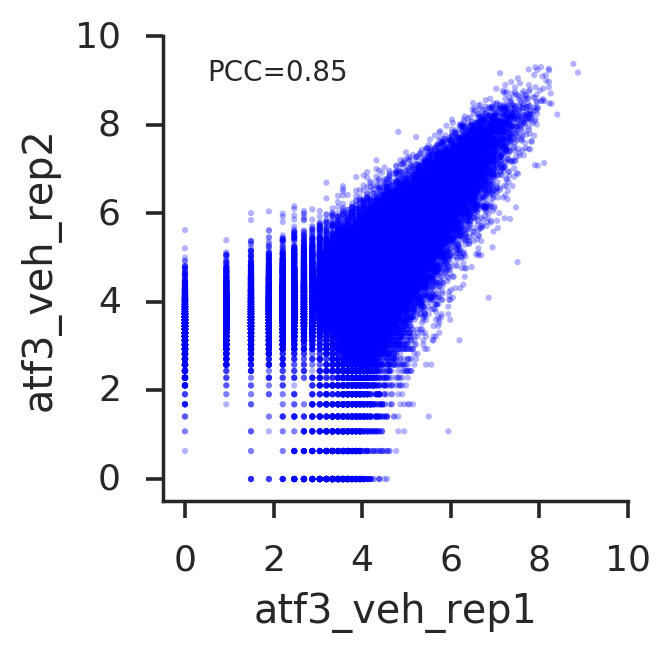

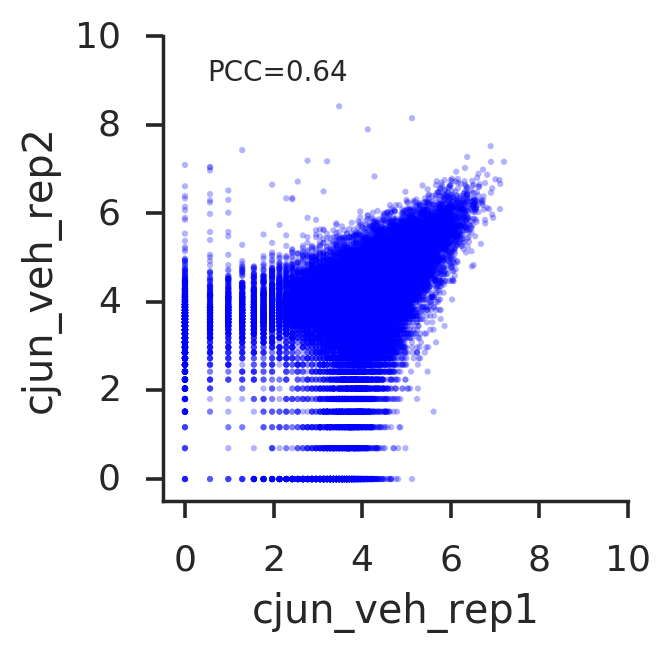

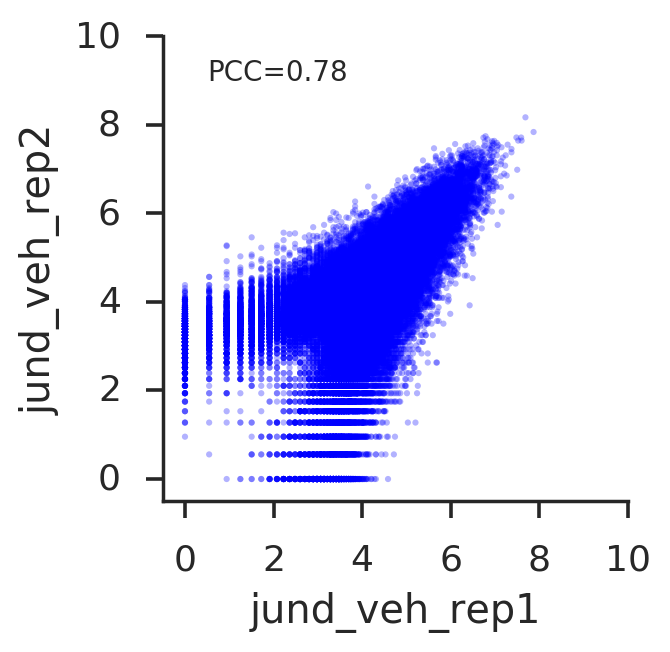

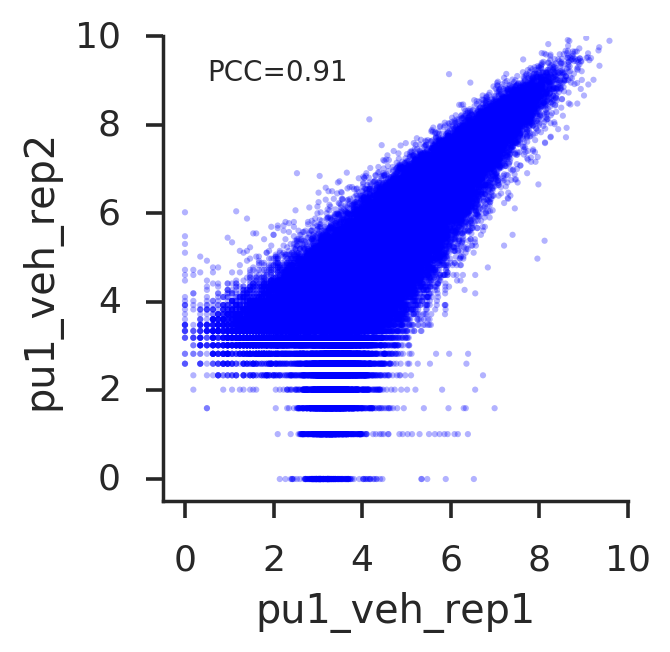

In [163]:
for treatment in ['veh']:
    for factor in ['atf3', 'cjun', 'jund', 'pu1']:
        rep1_label = '_'.join([factor, treatment, 'rep1'])
        rep2_label = '_'.join([factor, treatment, 'rep2'])
        rep1_indices = set(summary_frame[summary_frame[rep1_label] > 0].index.values)
        rep2_indices = set(summary_frame[summary_frame[rep2_label] > 0].index.values)
        idr_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'idr'])] > 0].index.values)
        indices = sorted(rep1_indices.union(rep2_indices).union(idr_indices))
        
        rep1_tags = annotated_frame.ix[indices, rep1_label].values
        rep2_tags = annotated_frame.ix[indices, rep2_label].values
        corr, pval = scipy.stats.pearsonr(rep1_tags, rep2_tags)
        with sns.axes_style('ticks'):
            plt.figure(figsize=(3,3))
            plt.scatter(np.log2(rep1_tags+1),
                        np.log2(rep2_tags+1),
                        edgecolor='None', 
                        s=5,
                        alpha=0.3)
            plt.annotate(xy=(0.5,9), s='PCC='+str(corr)[:4], size=10)
            plt.xlim(-0.5, 10)
            plt.ylim(-0.5, 10)
            ax = plt.gca()
            ax.set_aspect(1.0)
            plt.xlabel(rep1_label)
            plt.ylabel(rep2_label)
            sns.despine()
        plt.show()                                      

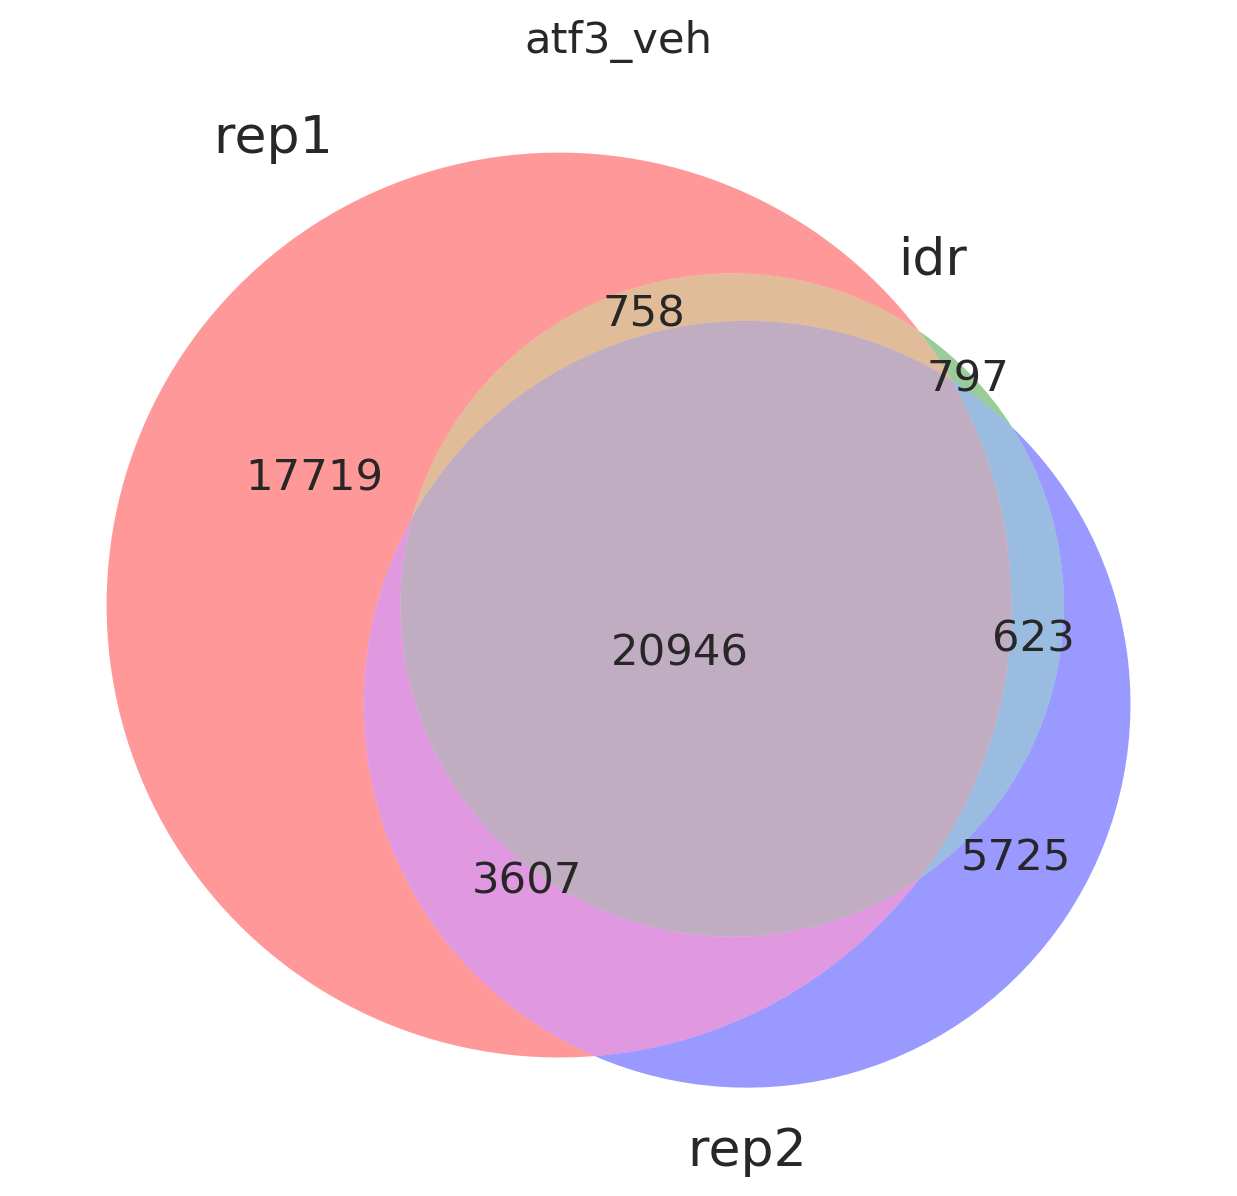

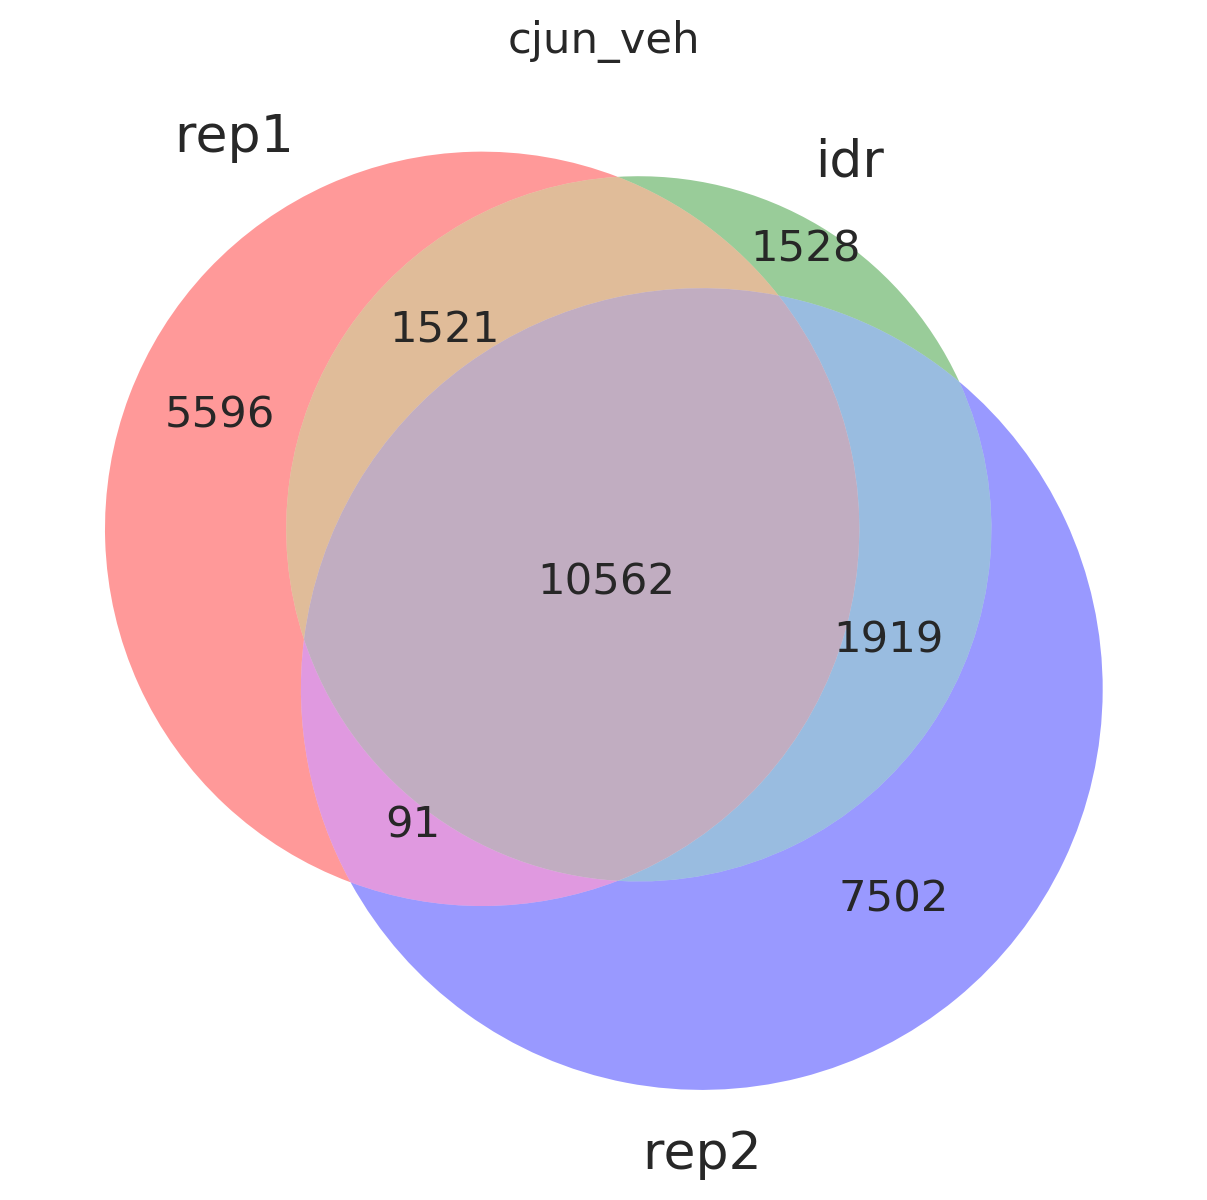

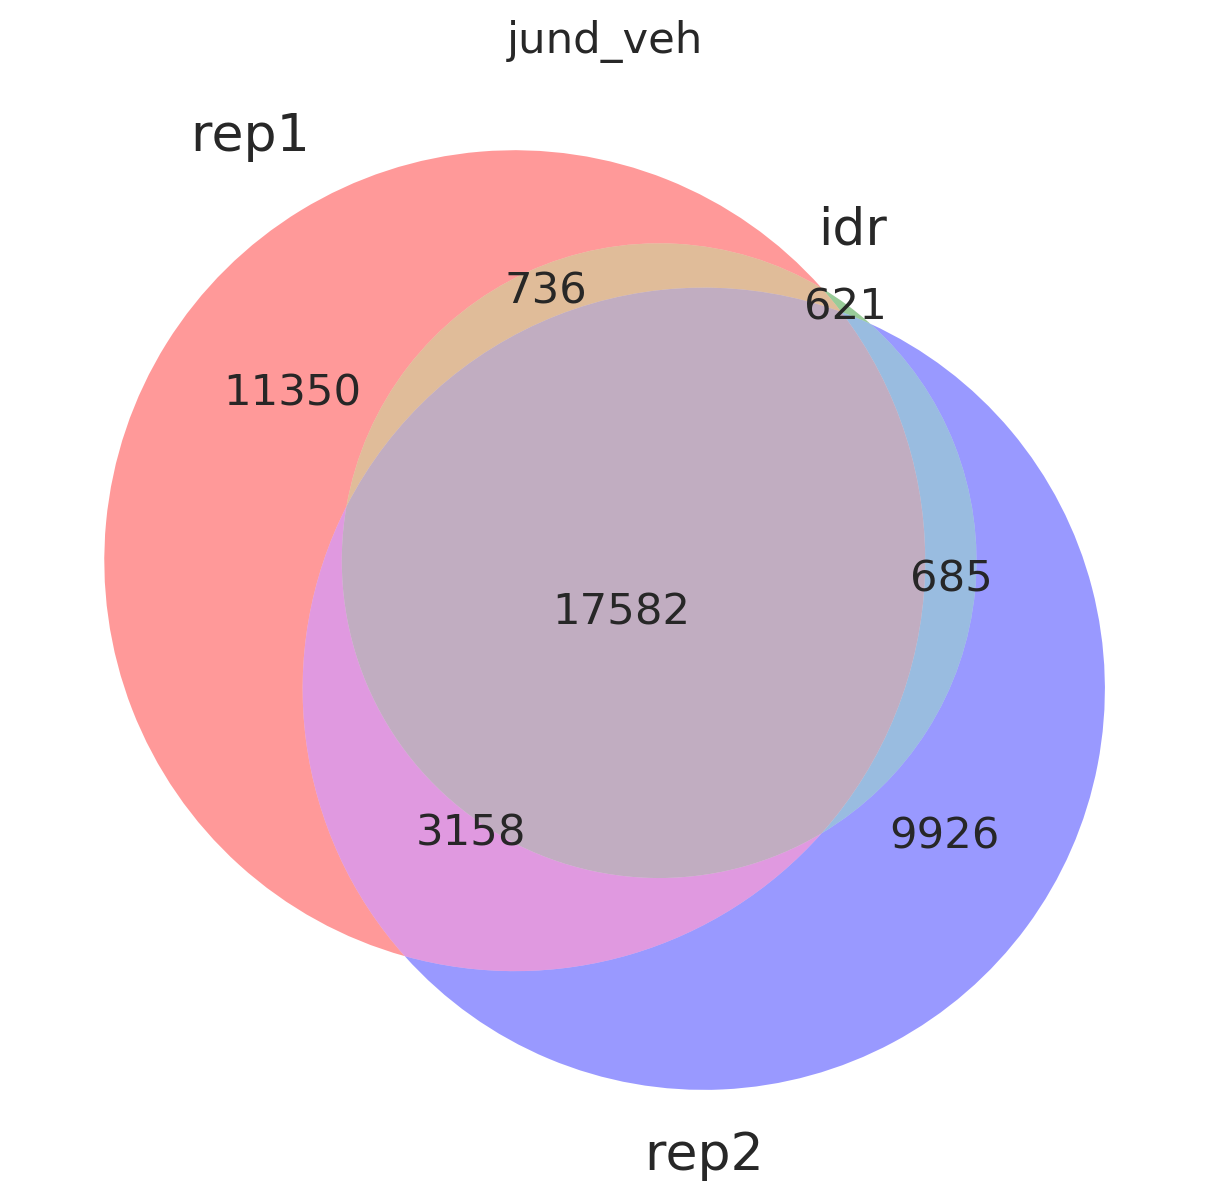

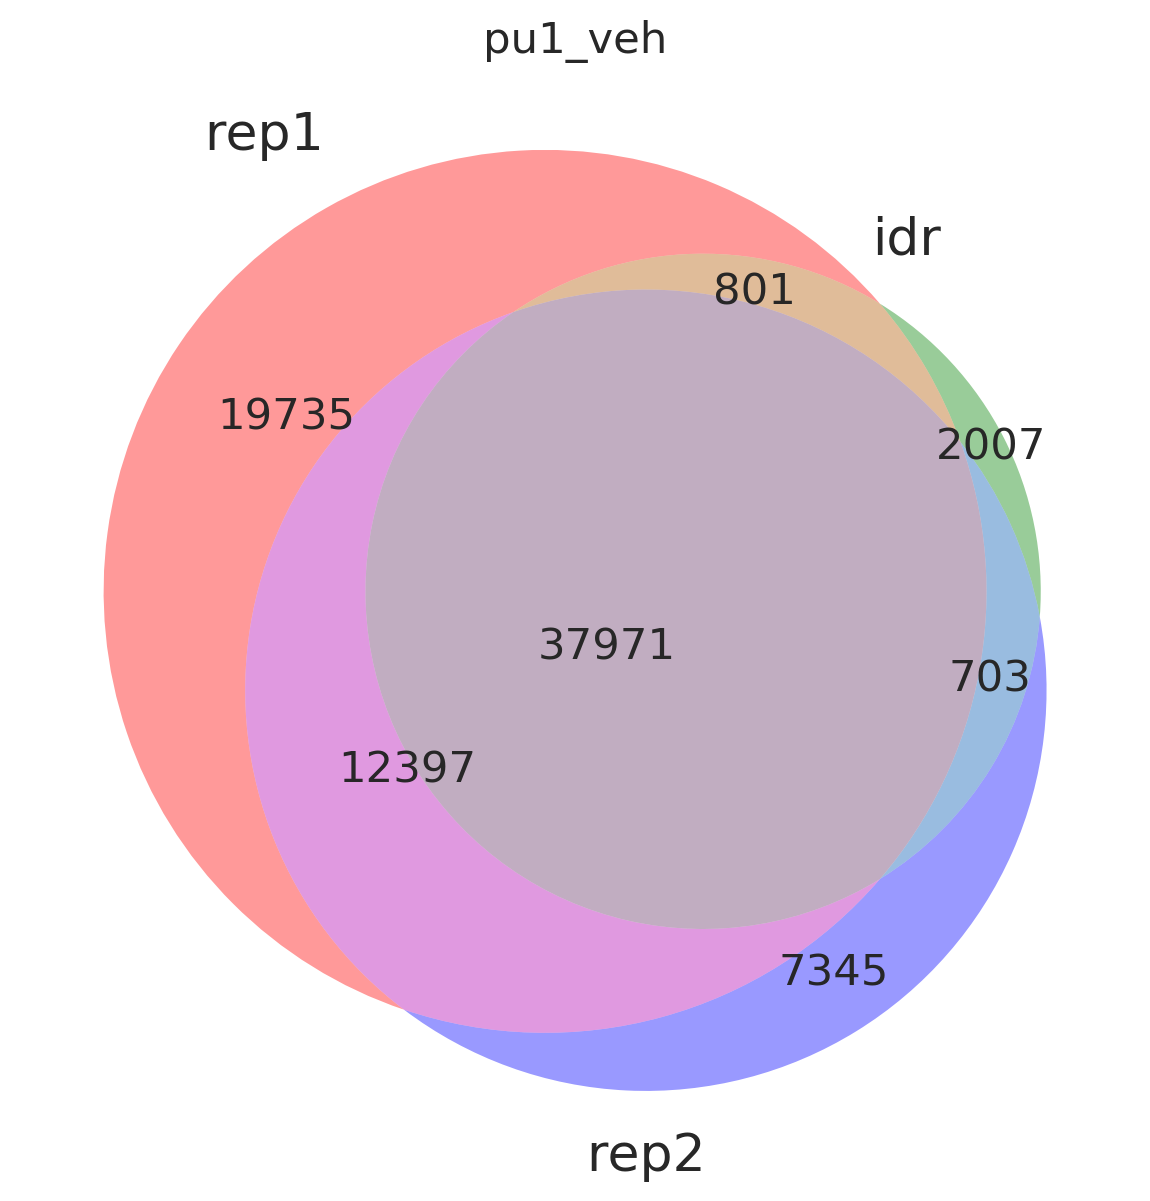

In [153]:
for treatment in ['veh']:
    for factor in ['atf3', 'cjun', 'jund', 'pu1']:
        rep1_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'rep1'])] > 0].index.values)
        rep2_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'rep2'])] > 0].index.values)
        idr_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'idr'])] > 0].index.values)
        matplotlib_venn.venn3([rep1_indices, idr_indices, rep2_indices], set_labels=['rep1', 'idr', 'rep2'])
        plt.title('_'.join([factor, treatment]))
        plt.show()

## Visualize Difference Between Monomers

In [605]:
def quantile_normalize(vals1, vals2):
    '''
    input: two scalar arrays
    output: two quantile normalized scalar arrays
    '''
    vals1 = np.array(vals1)
    vals2 = np.array(vals2)
    
    ranks_1 = scipy.stats.rankdata(vals1, method = 'ordinal')
    ranks_2 = scipy.stats.rankdata(vals2, method = 'ordinal')
    
    sorted_vals_1 = sorted(vals1)
    sorted_vals_2 = sorted(vals2)
    means = np.mean([sorted_vals_1,sorted_vals_2], axis=0)
    
    rank_mean_dict = dict(zip(sorted(ranks_1), sorted(means)))
    normalized_vals_1 = np.array([rank_mean_dict[x] for x in ranks_1])
    normalized_vals_2 = np.array([rank_mean_dict[x] for x in ranks_2])
    return normalized_vals_1, normalized_vals_2

In [603]:
conditions = set()
for col in annotated_frame.columns[6:]:
    condition = '_'.join(col.split('_')[:2])
    conditions.add(condition)
annotated_mean_frame = annotated_frame[[]]
for condition in sorted(conditions):
    mean_tags = annotated_frame[[x for x in annotated_frame.columns if condition in x]].mean(axis=1)
    annotated_mean_frame[condition] = mean_tags.values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [606]:
indices = set()
factors=['atf3', 'cjun', 'jund']
for treatment in ['veh']:
    for factor in factors:
        idr_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'idr'])] > 0].index.values)
        indices = indices.union(idr_indices)
indices = sorted(indices)
data = annotated_mean_frame[annotated_mean_frame.index.isin(indices)][['atf3_veh', 'cjun_veh', 'jund_veh']]
data = data[data.min(axis=1)>0]
normed_mean_data = data[[]]
for col in data:
    normalized_vals_1, normalized_vals_2 = quantile_normalize(data['atf3_veh'].values, data[col].values)
    normed_mean_data[col] = normalized_vals_2


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [607]:
medians = normed_mean_data.median(axis=1)
mins = normed_mean_data.min(axis=1)
maxes = normed_mean_data.max(axis=1)
ranges = maxes - mins
normed_distances = normed_mean_data[[]]
for col in data:
    normed_distances[col] = (data[col].values- medians)/ranges

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


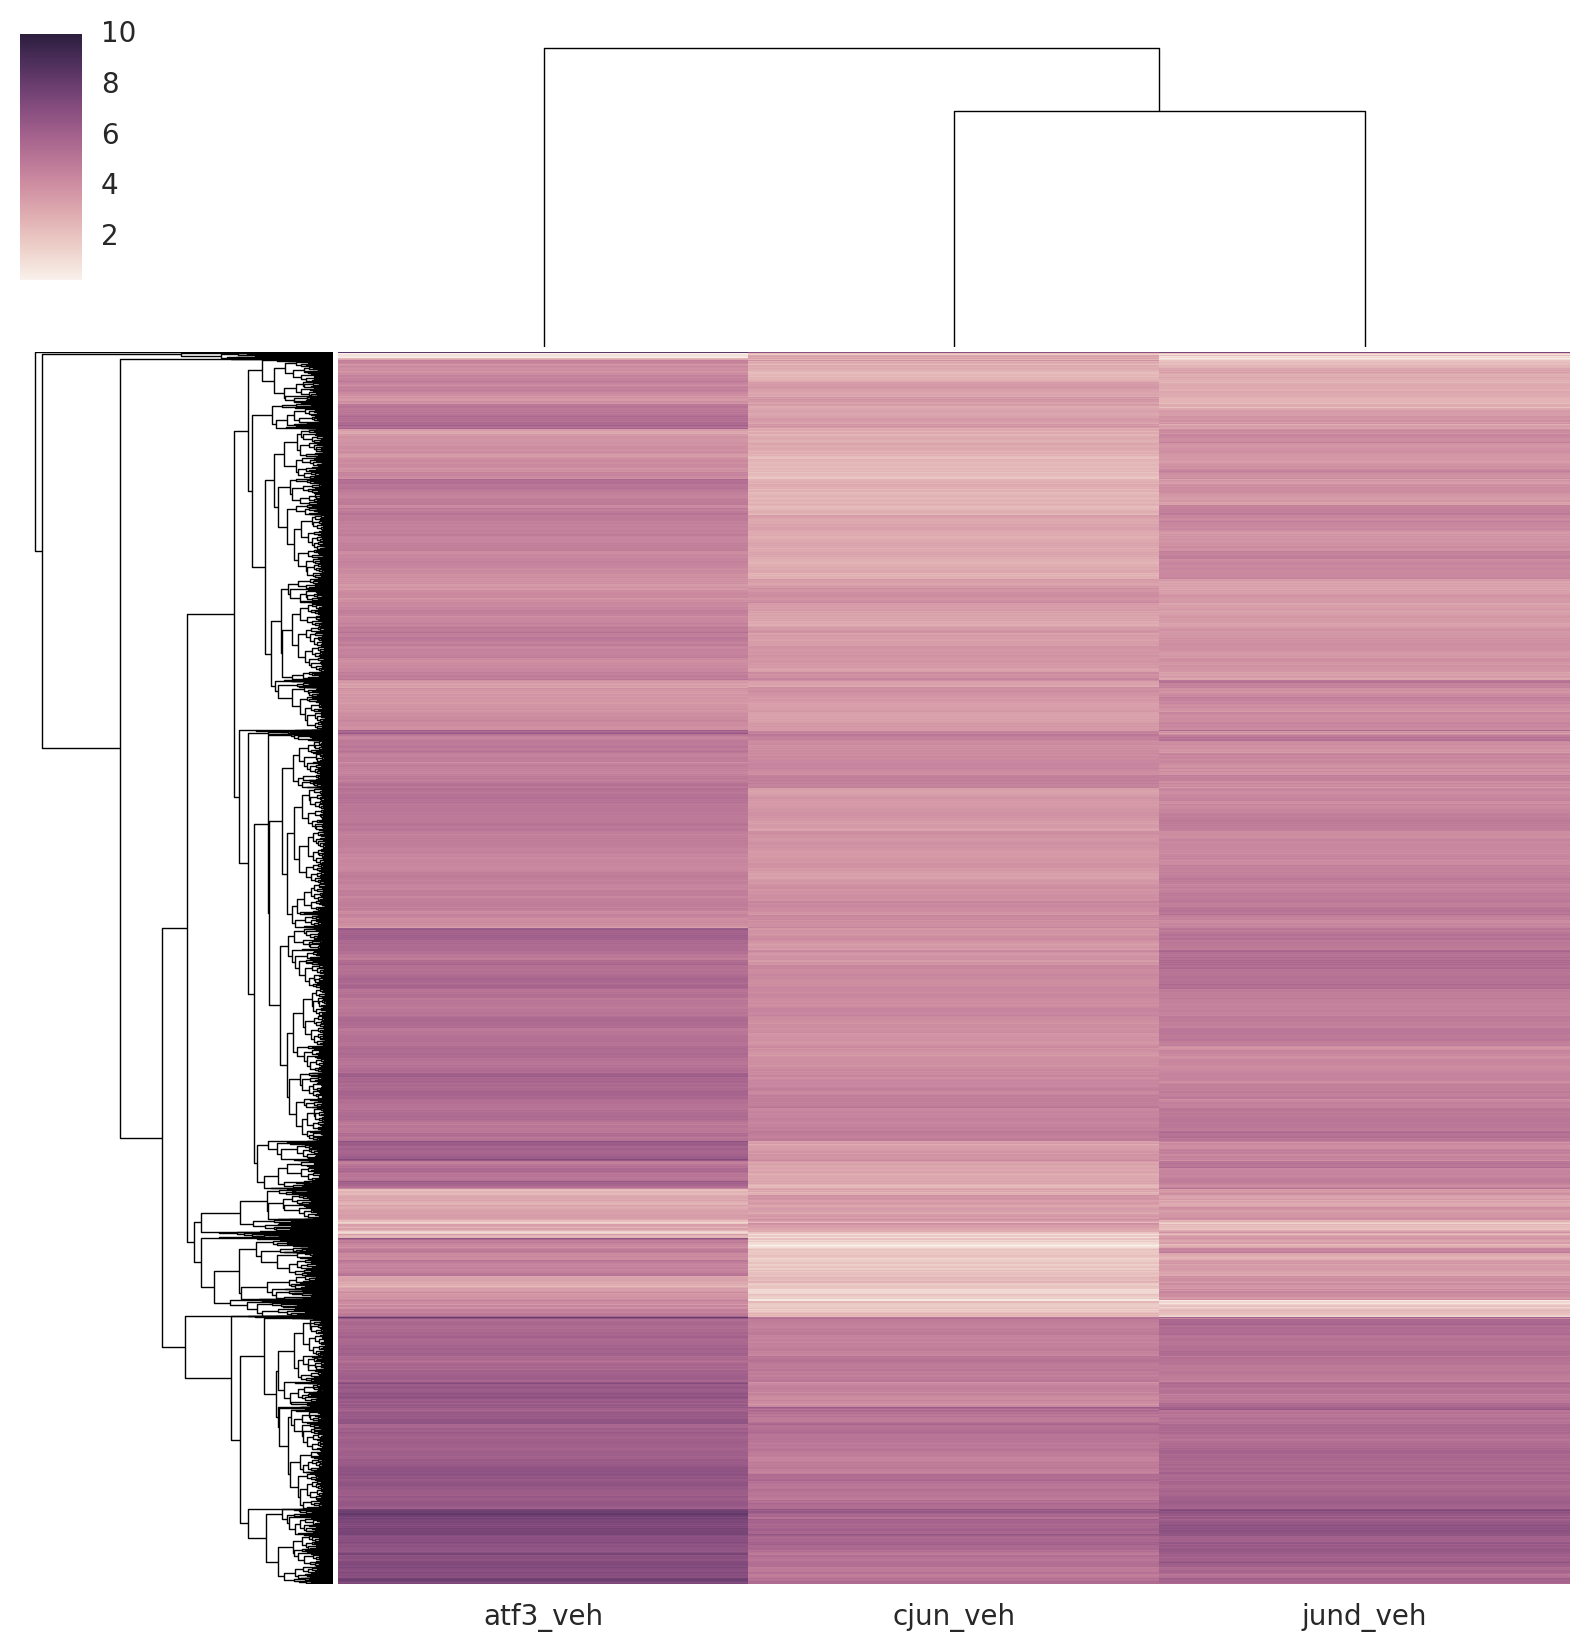

In [608]:
sns.clustermap(np.log2(data+1), 
               yticklabels=False,
               vmax=10,
#                metric = 'correlation',
#                method = 'centroid'
              )

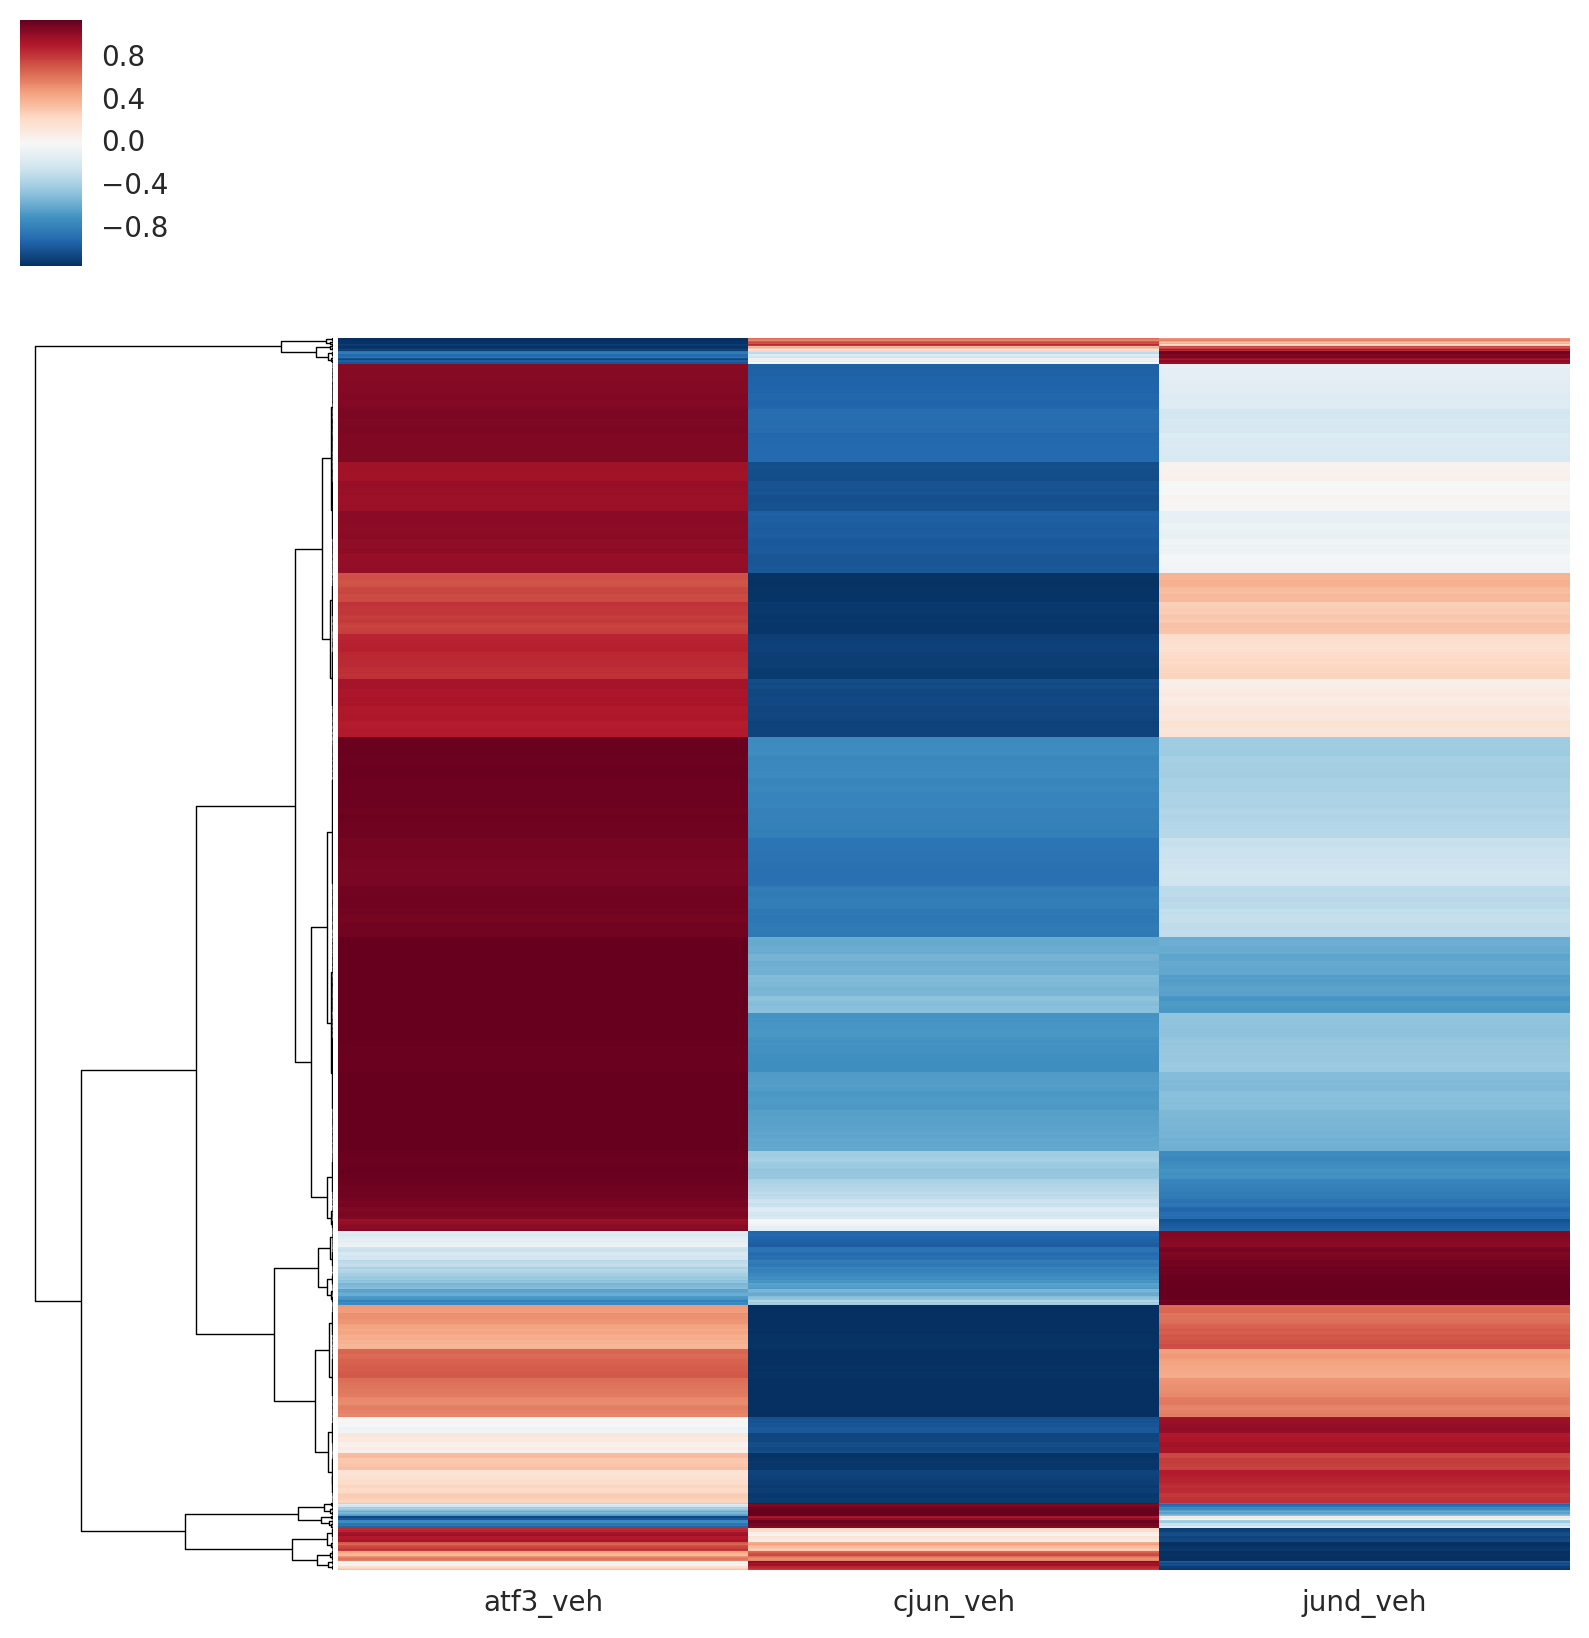

In [609]:
cg = sns.clustermap(data,
                    yticklabels=False,
                    col_cluster=False,
                    z_score=0,
                    metric = 'correlation',
                    method = 'centroid')

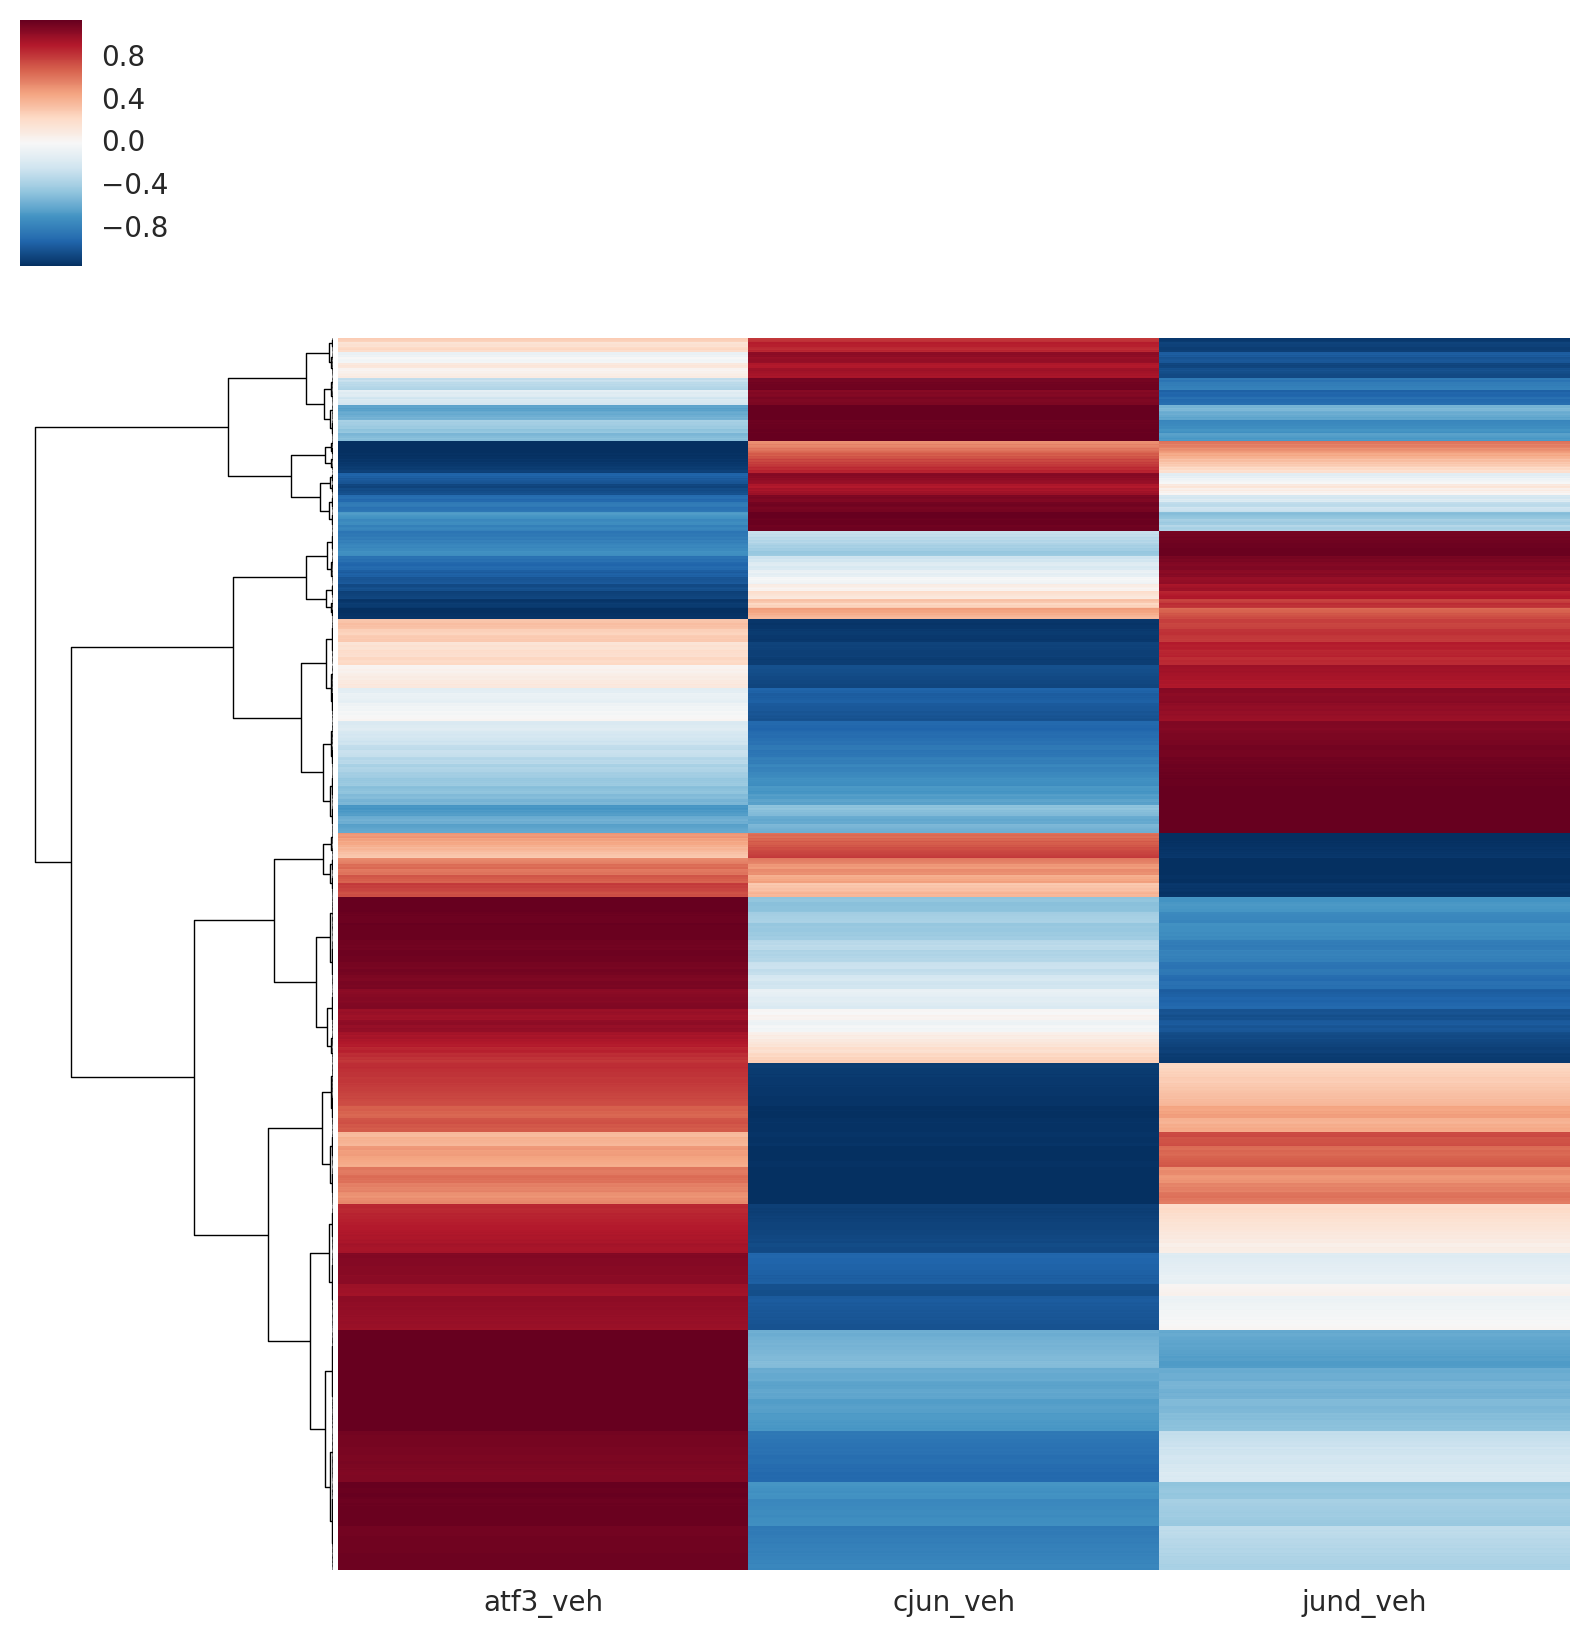

In [610]:
cg = sns.clustermap(normed_mean_data,
                    yticklabels=False,
                    z_score=0,
                    col_cluster=False,
                    metric = 'correlation',
                    method = 'centroid')

In [686]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

(29614, 6)
(28382, 6)
(28382, 6)


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


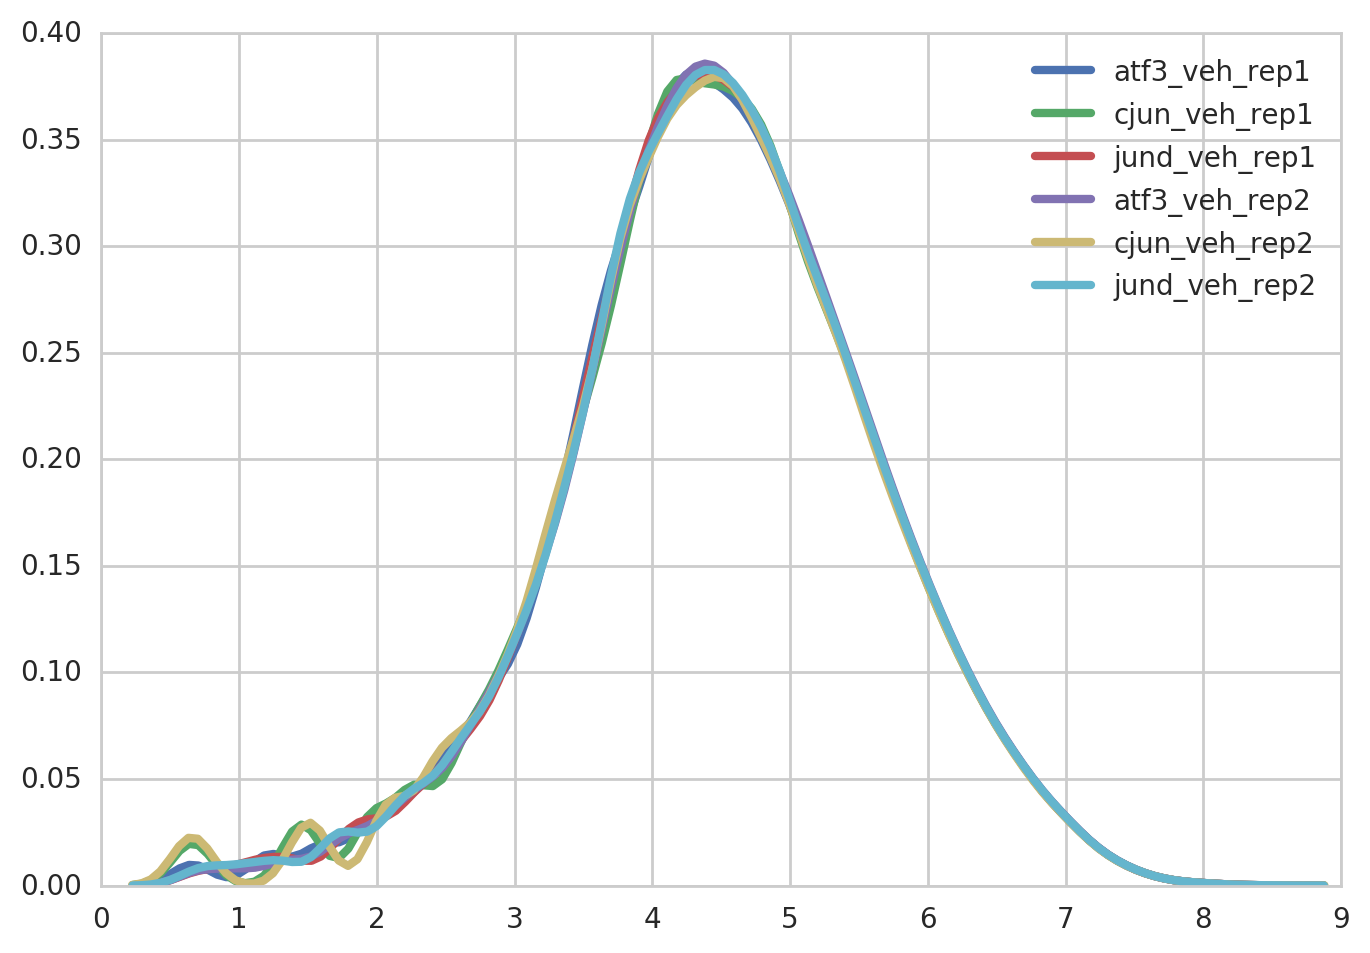

In [687]:
indices = set()
factors=['atf3', 'cjun', 'jund']
treatment = 'veh'
for factor in factors:
    idr_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'idr'])] > 0].index.values)
    indices = indices.union(idr_indices)
indices = sorted(indices)
rep_cols = [f + '_' + treatment + '_rep1' for f in factors] + [f + '_' + treatment + '_rep2' for f in factors]
data = annotated_frame[annotated_frame.index.isin(indices)][rep_cols]
print(data.shape)
data = data[data.min(axis=1)>0]
print(data.shape)
# data = data[data.max(axis=1) >= 16]
print(data.shape)
normed_data = data[[]]
mean_vals = data.mean(axis=1)
quant_normed_data = quantile_normalize_df(data)

for col in data:
    with sns.axes_style('whitegrid'):
        sns.kdeplot(np.log2(quant_normed_data[col]+1), label = col, linewidth=3)

(28382, 6)


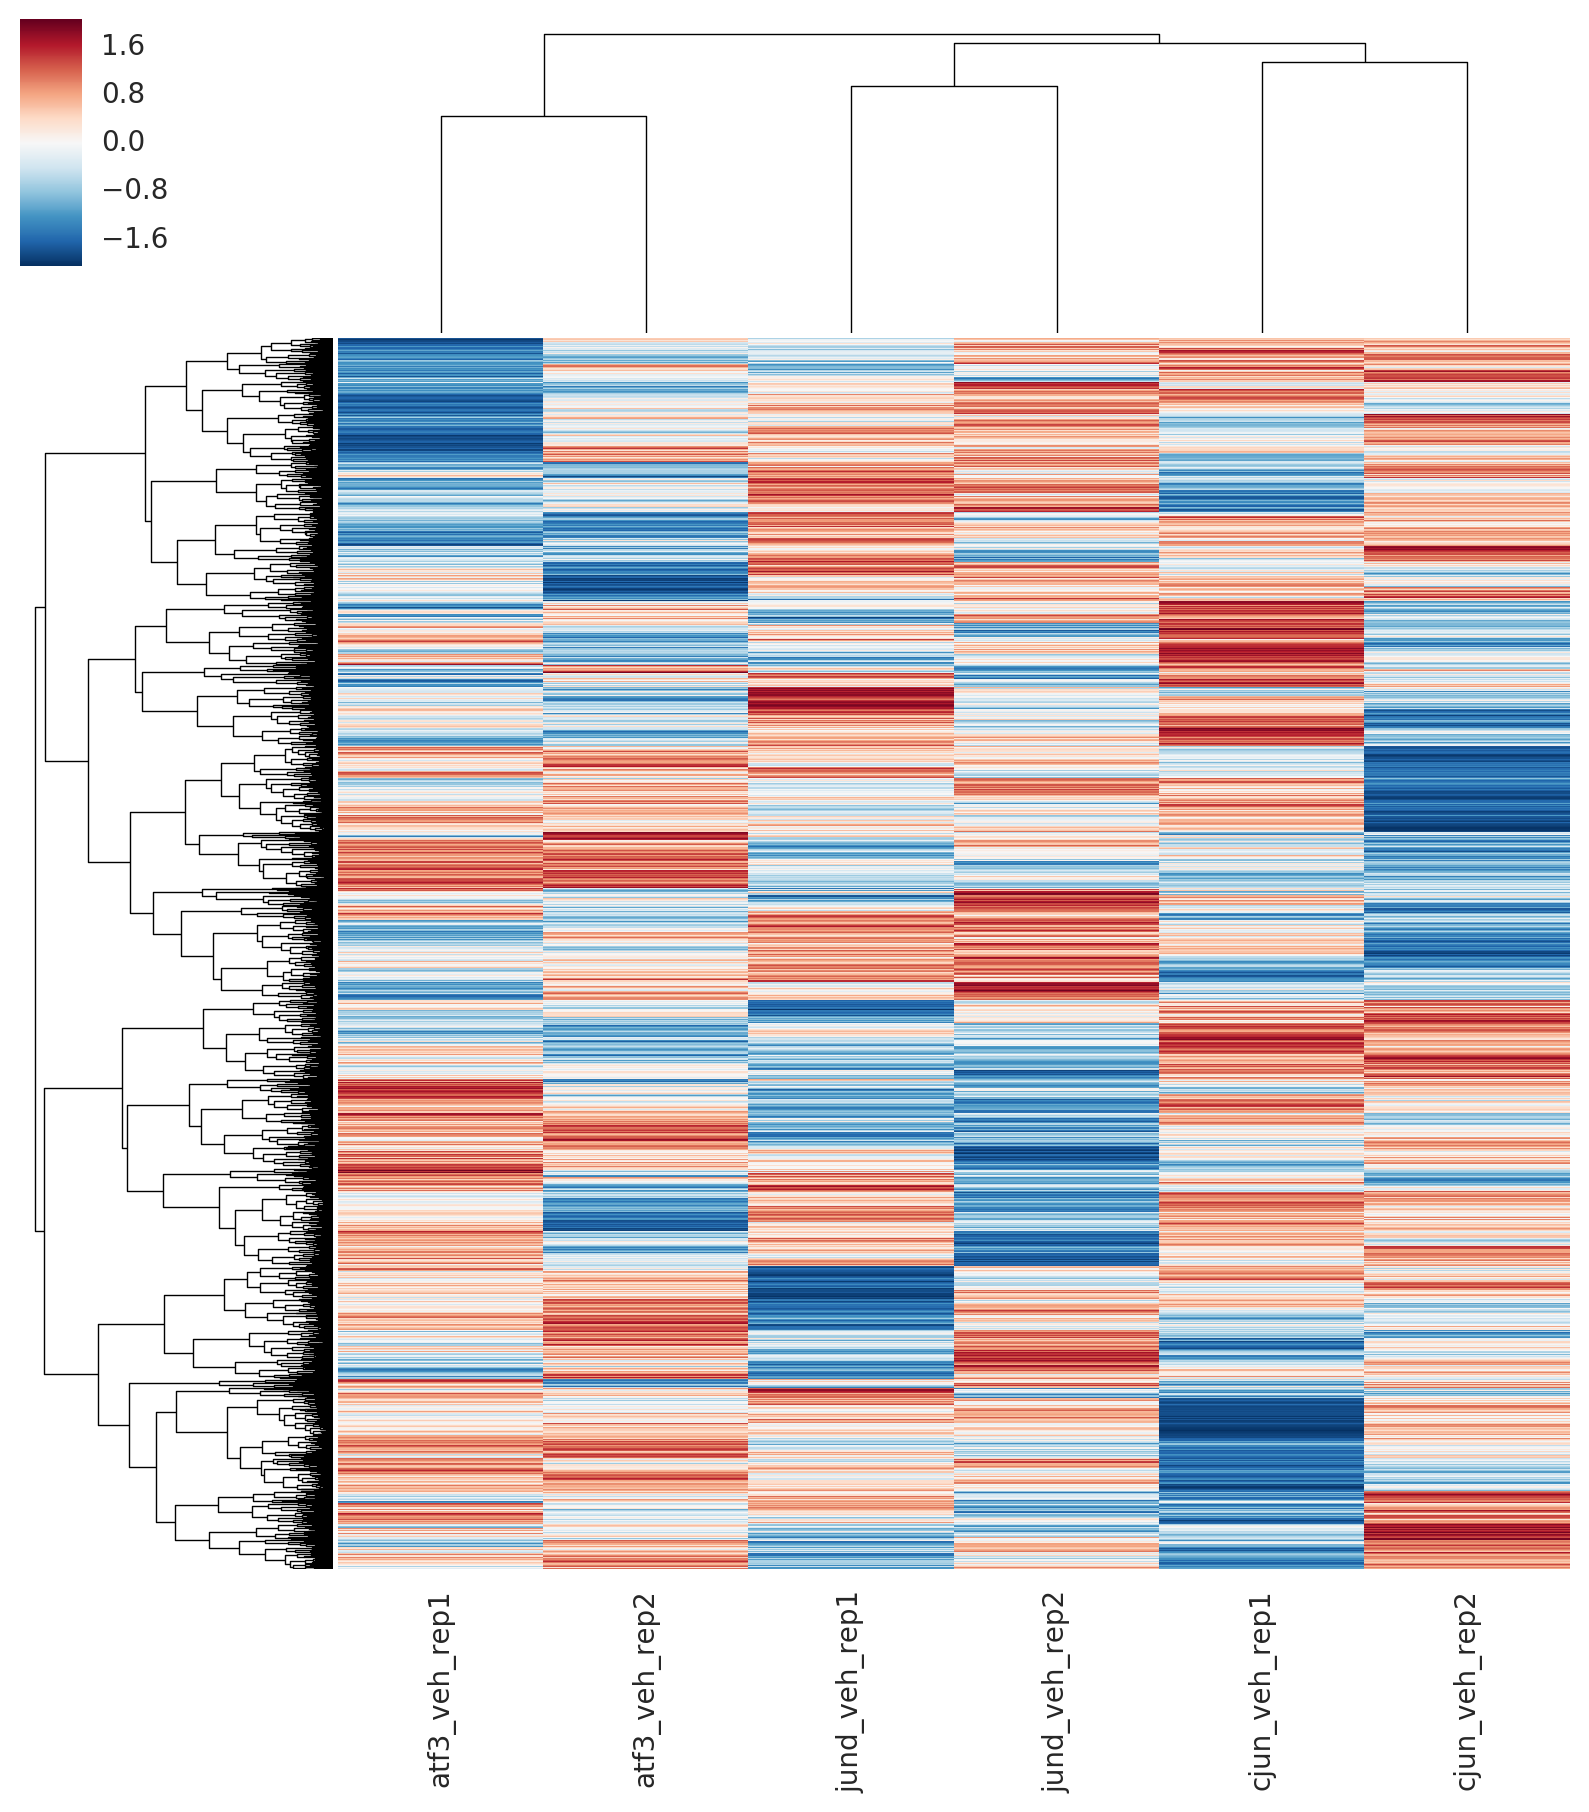

In [700]:
to_plot = quant_normed_data
print(to_plot.shape)
cg = sns.clustermap(np.log2(to_plot+1),
#                     to_plot,
                    yticklabels=False,
                    col_cluster=True,
                    z_score=0,
                    metric = 'correlation',
#                     standard_scale =0,
#                     cmap='Blues',
#                     vmin=-2.5,
#                     vmax=2.5
                   )

plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=90);

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


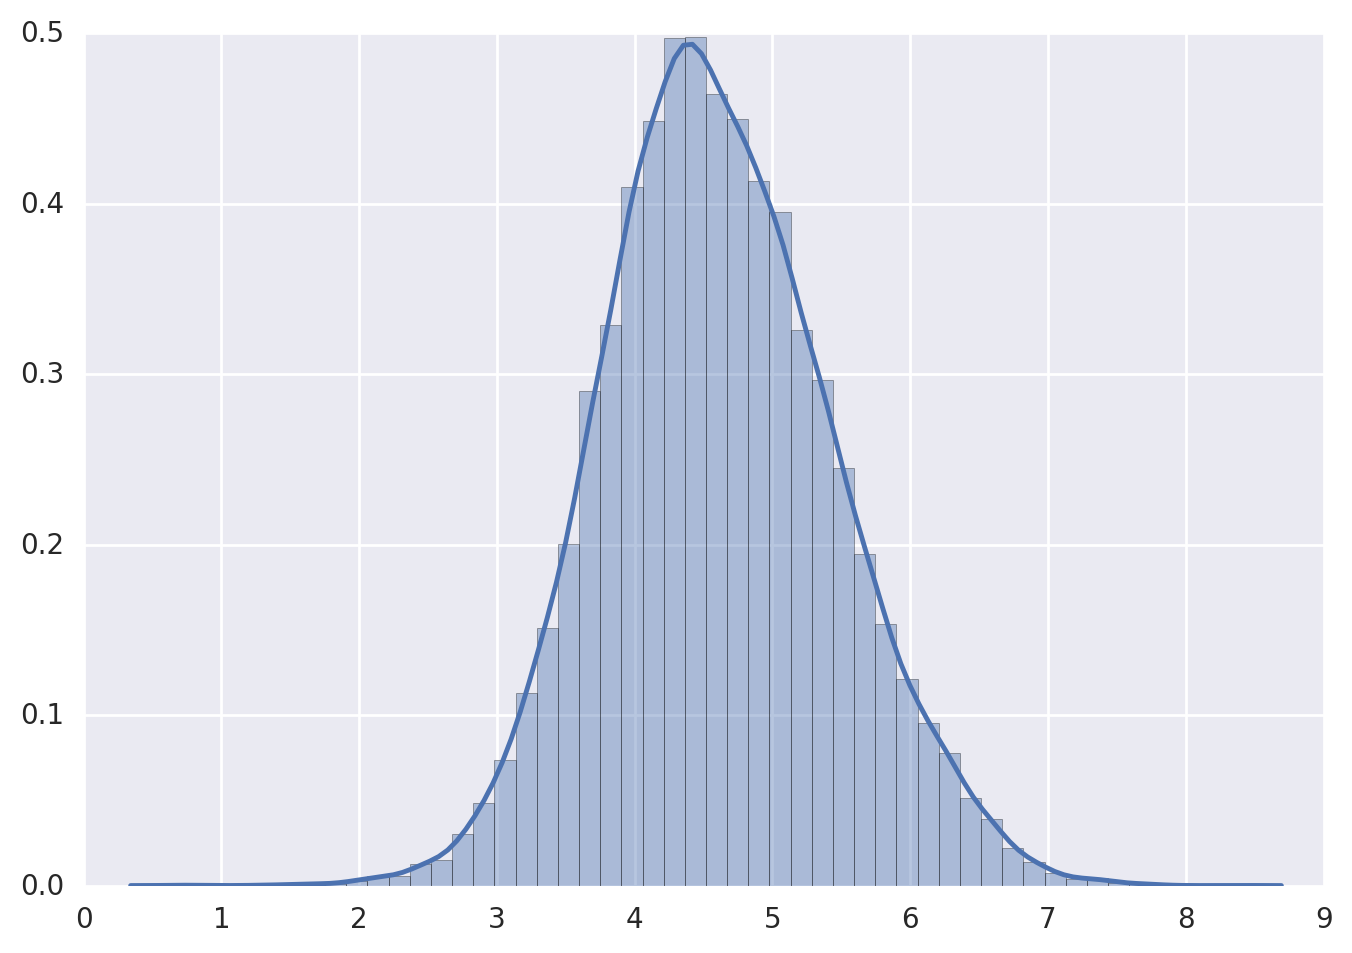

In [688]:
sns.distplot(np.log2(quant_normed_data.max(axis=1) - quant_normed_data.min(axis=1)))

(8698, 6)


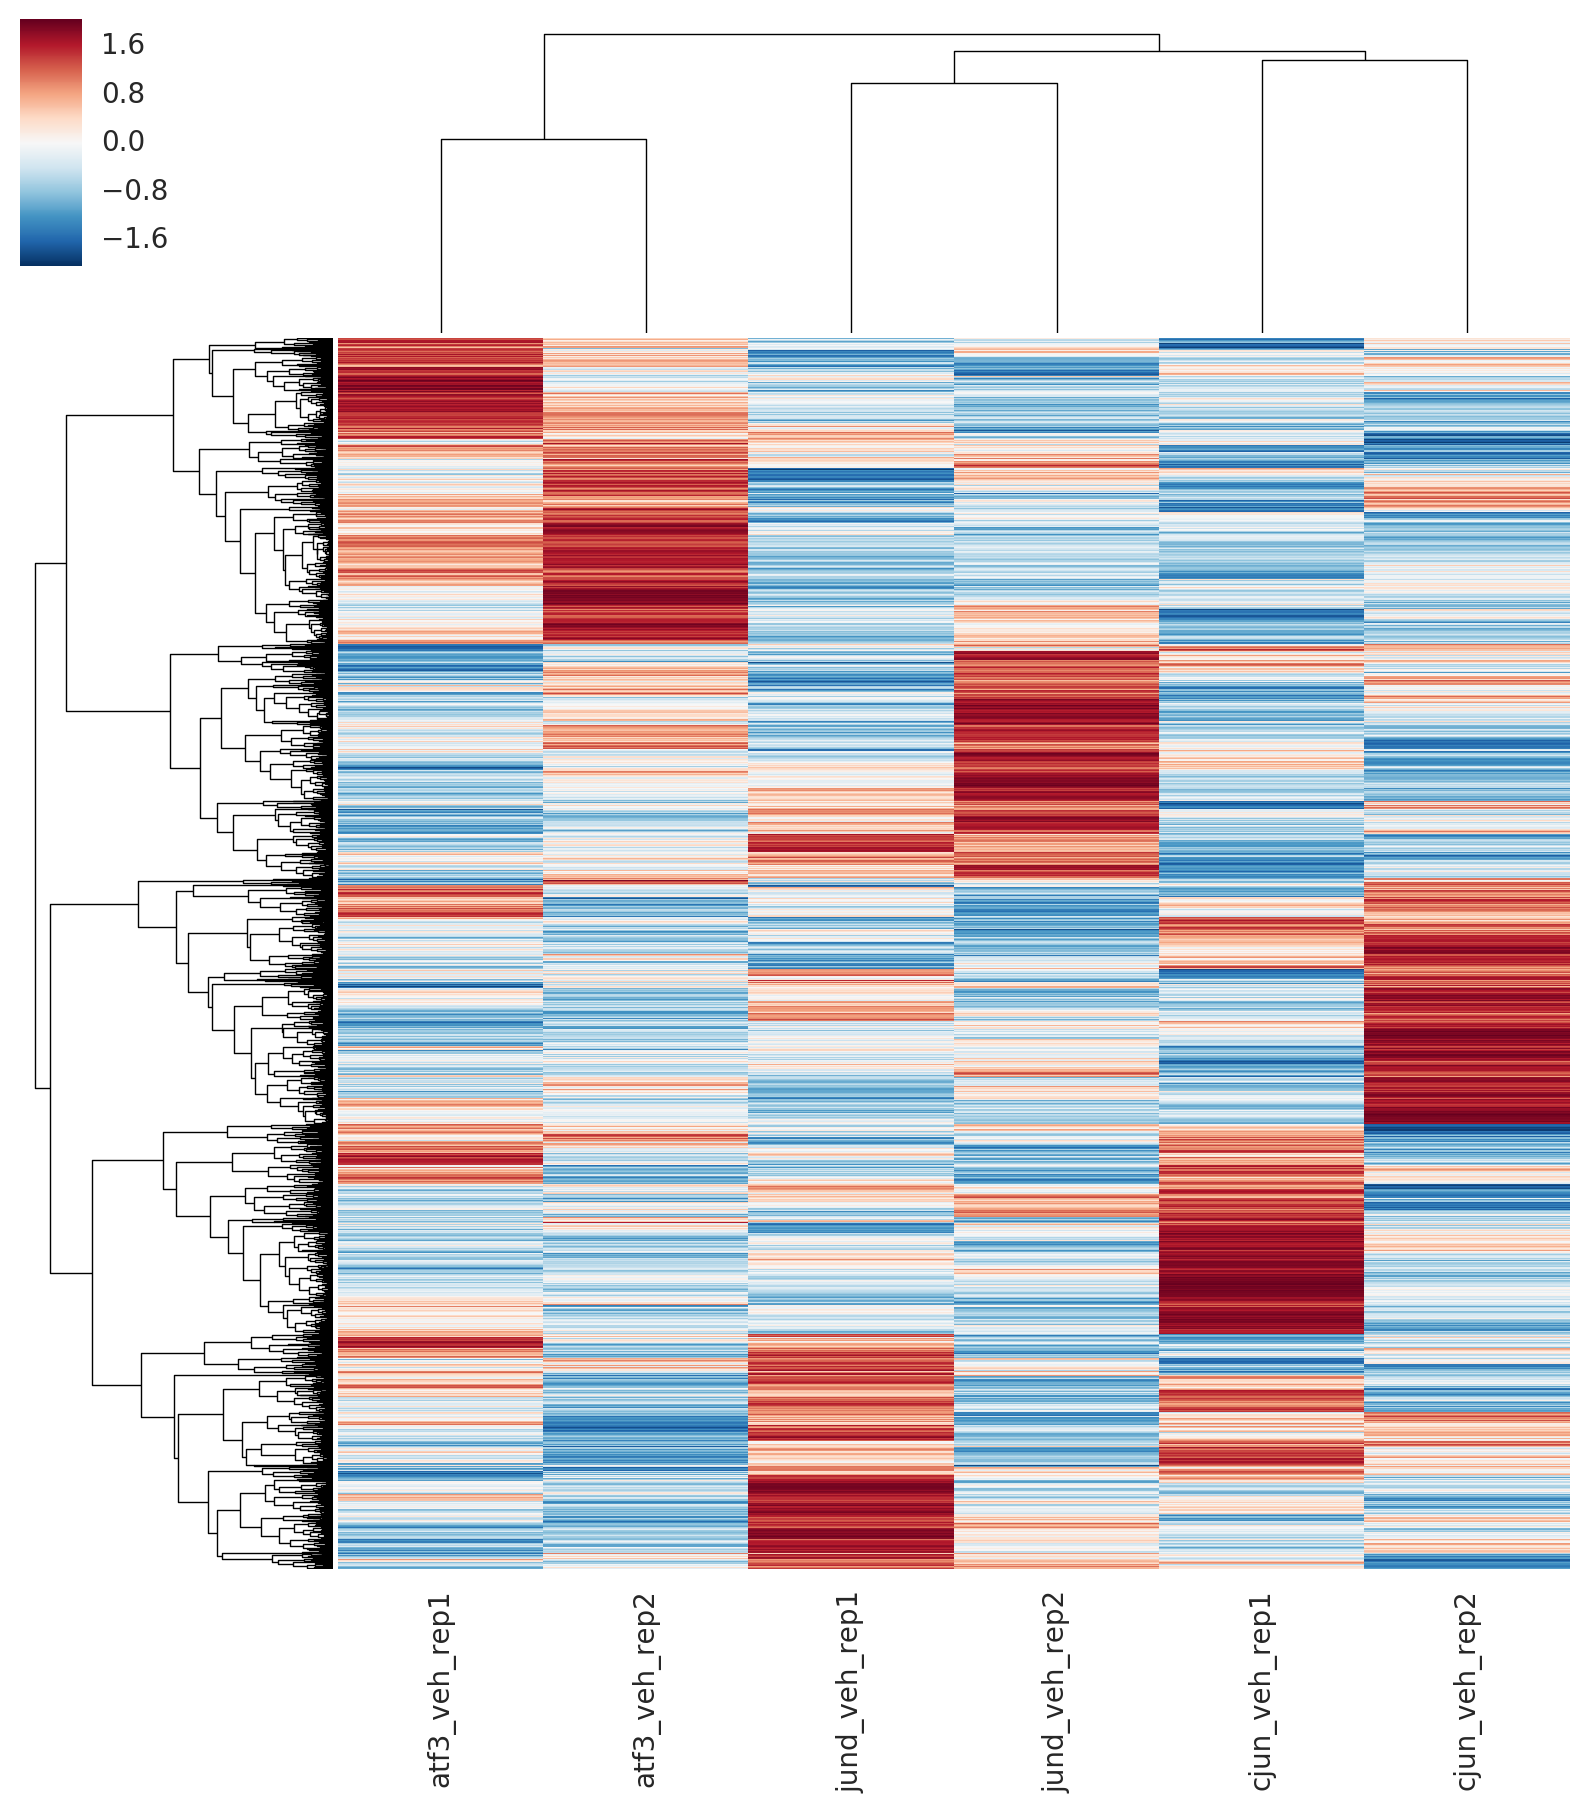

In [701]:
to_plot = quant_normed_data[quant_normed_data.max(axis=1) - quant_normed_data.min(axis=1) >= 32]+1
# to_plot = quant_normed_data
print(to_plot.shape)
cg = sns.clustermap(#np.log2(to_plot+1),
                    to_plot,
                    yticklabels=False,
                    col_cluster=True,
                    z_score=0,
                    metric = 'correlation',
#                     standard_scale =0,
#                     cmap='Blues',
#                     vmin=-2.5,
#                     vmax=2.5
                   )
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), 
#          fontsize=7, 
#          rotation=0);
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=90);

In [706]:
def corrfunc(x, y, **kws):
    r, _ = scipy.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

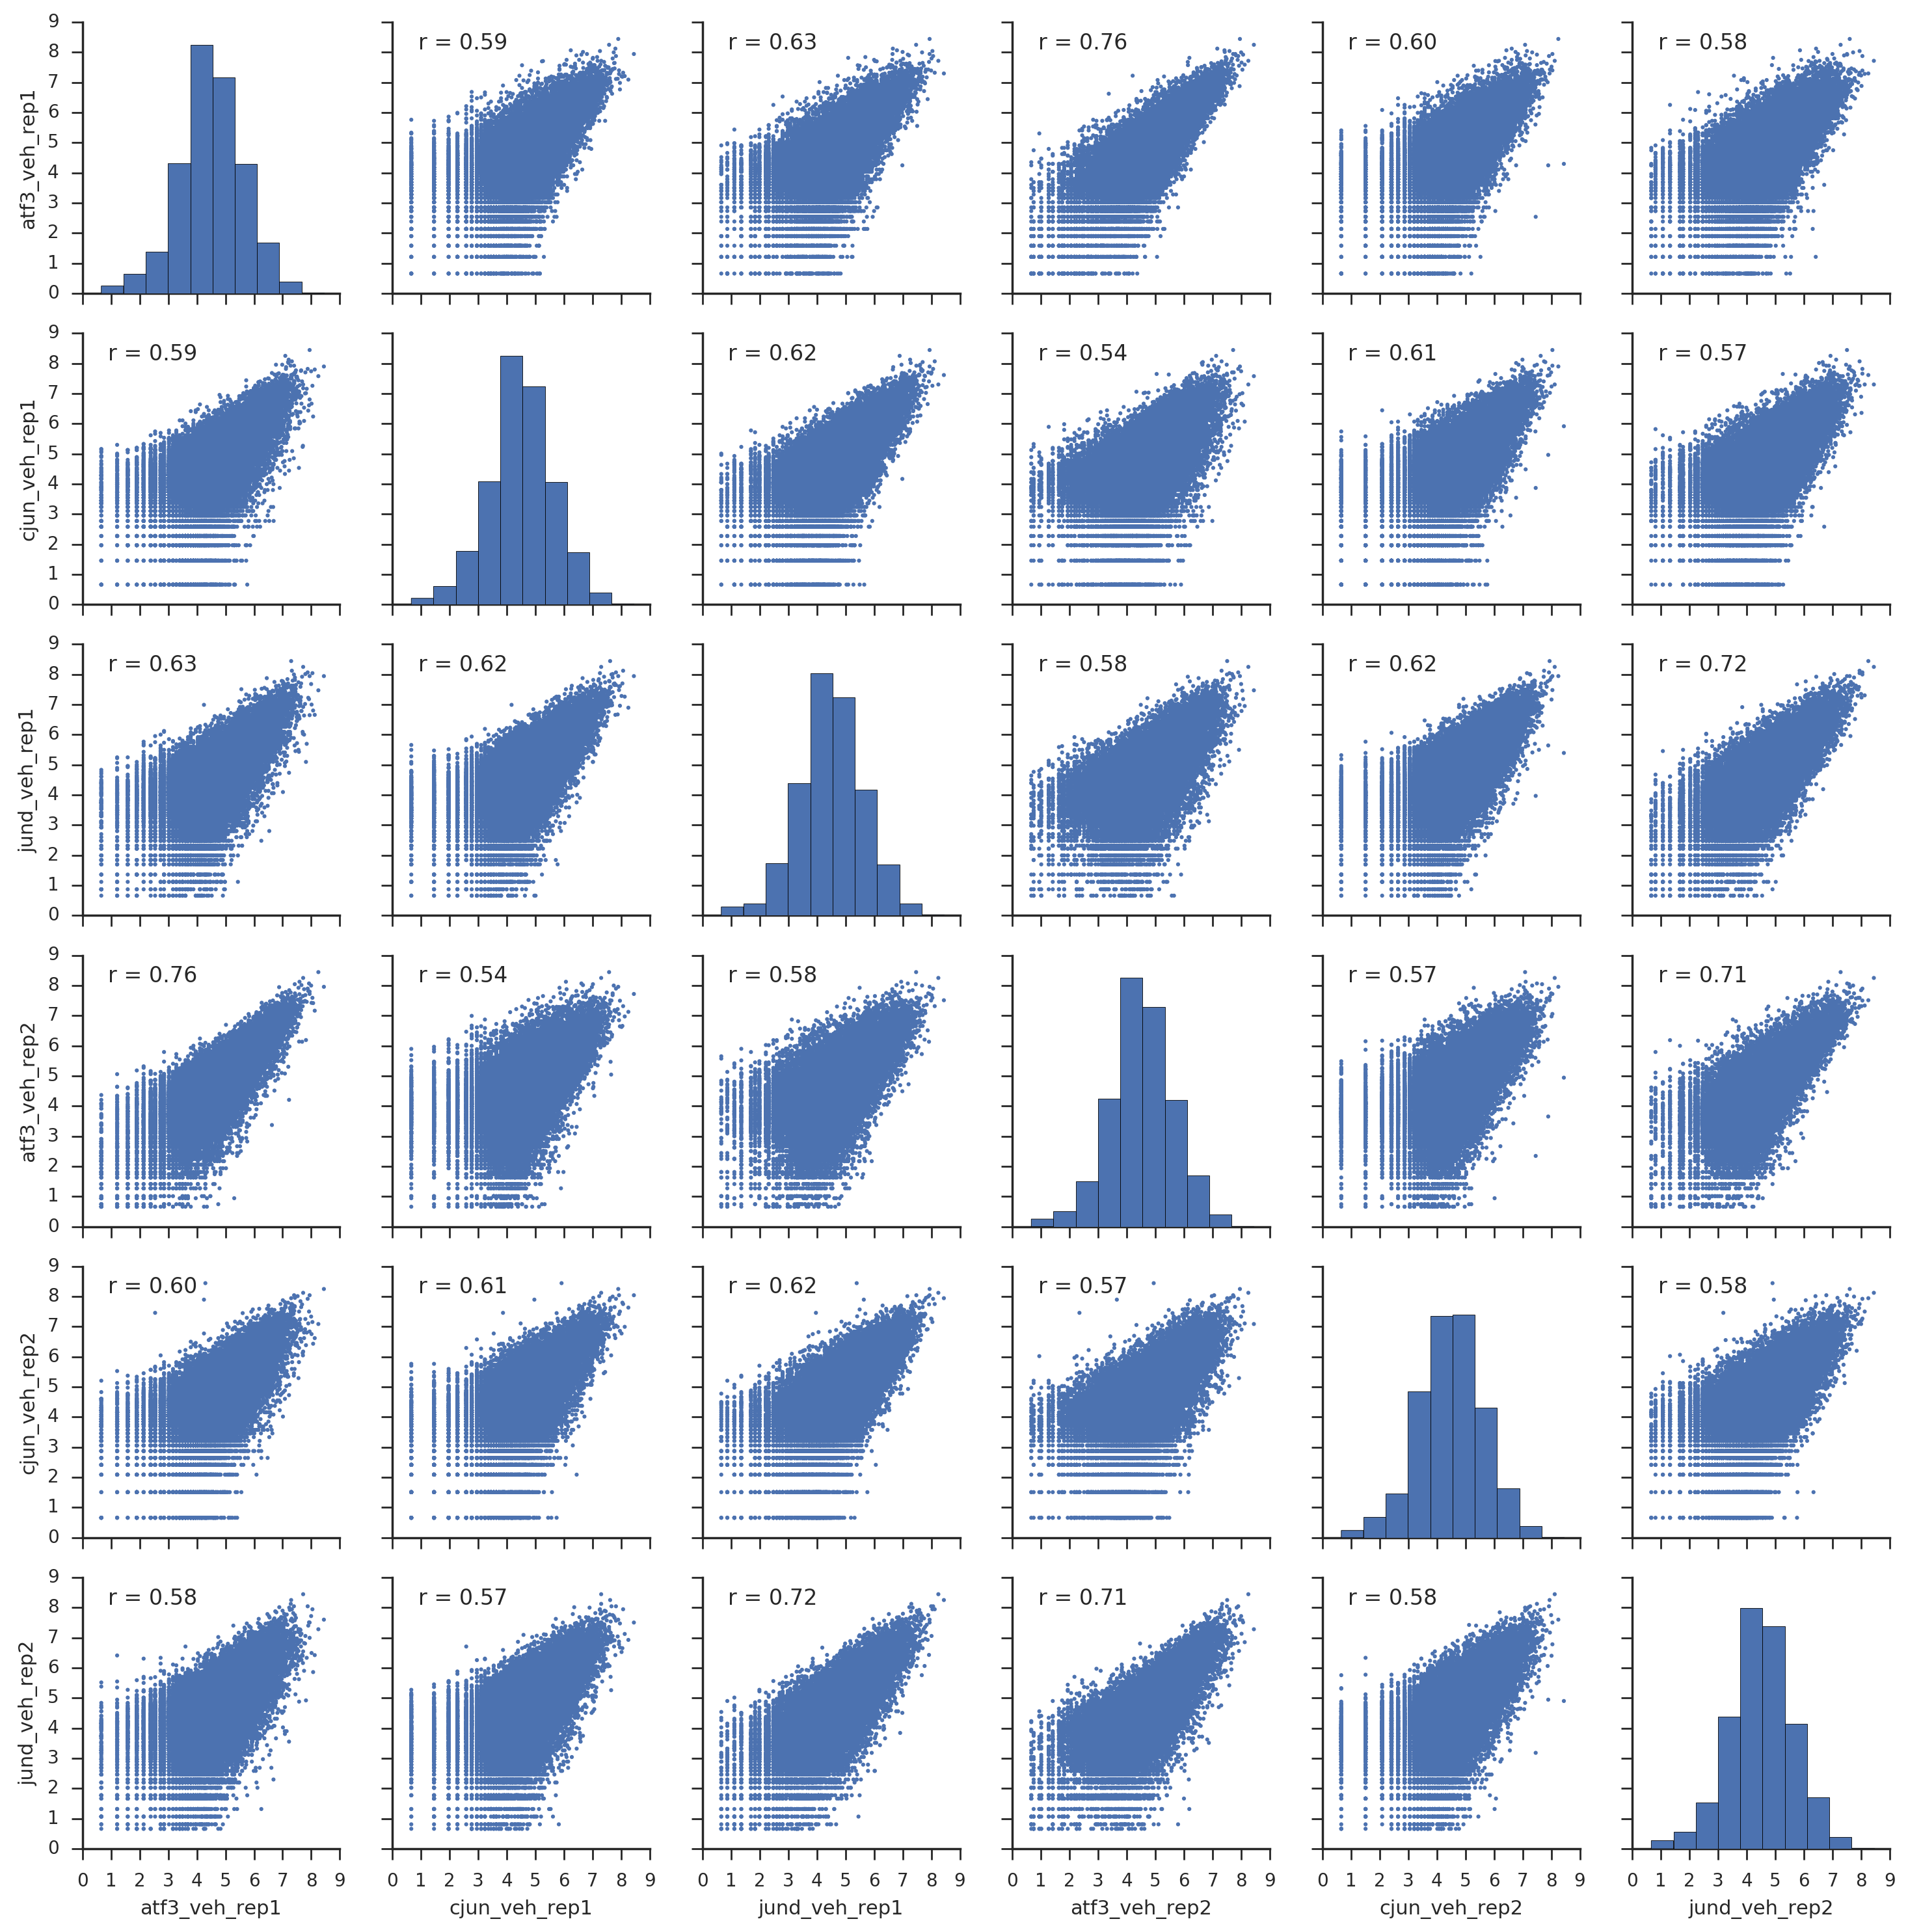

In [714]:
with sns.axes_style('ticks'):    
    g= sns.pairplot(np.log2(quant_normed_data+1), 
                    kind = 'scatter',
                    plot_kws={'s':5,'edgecolor':'None'}
                   )
    
    g.map_lower(corrfunc)
    g.map_upper(corrfunc)
#     g.map_lower(sns.despine())
#     g.map_upper(sns.despine())

## Compare Models

In [332]:
sample_weights_dict = {}
for f in os.listdir('./tba_output/'):
    if 'coefficients' in f:
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[1:4])
        sample_weights_dict[sample] = mean_weights
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)

In [451]:
rep1_weights = pd.Series(data=mean_weights_frame[rep1_label].values,
                                 index=mean_weights_frame.index.values)

In [453]:
idr_weights = pd.Series(data=mean_weights_frame[idr_label].values,
                                index=mean_weights_frame.index.values)

In [454]:
small_weights = idr_weights[idr_weights<=1.5]

In [467]:
np.exp(.08)

1.0832870676749586

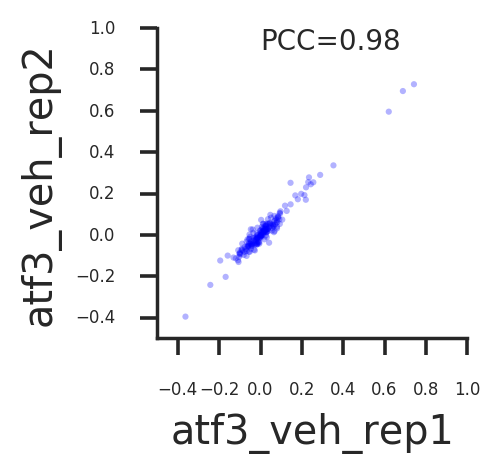

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


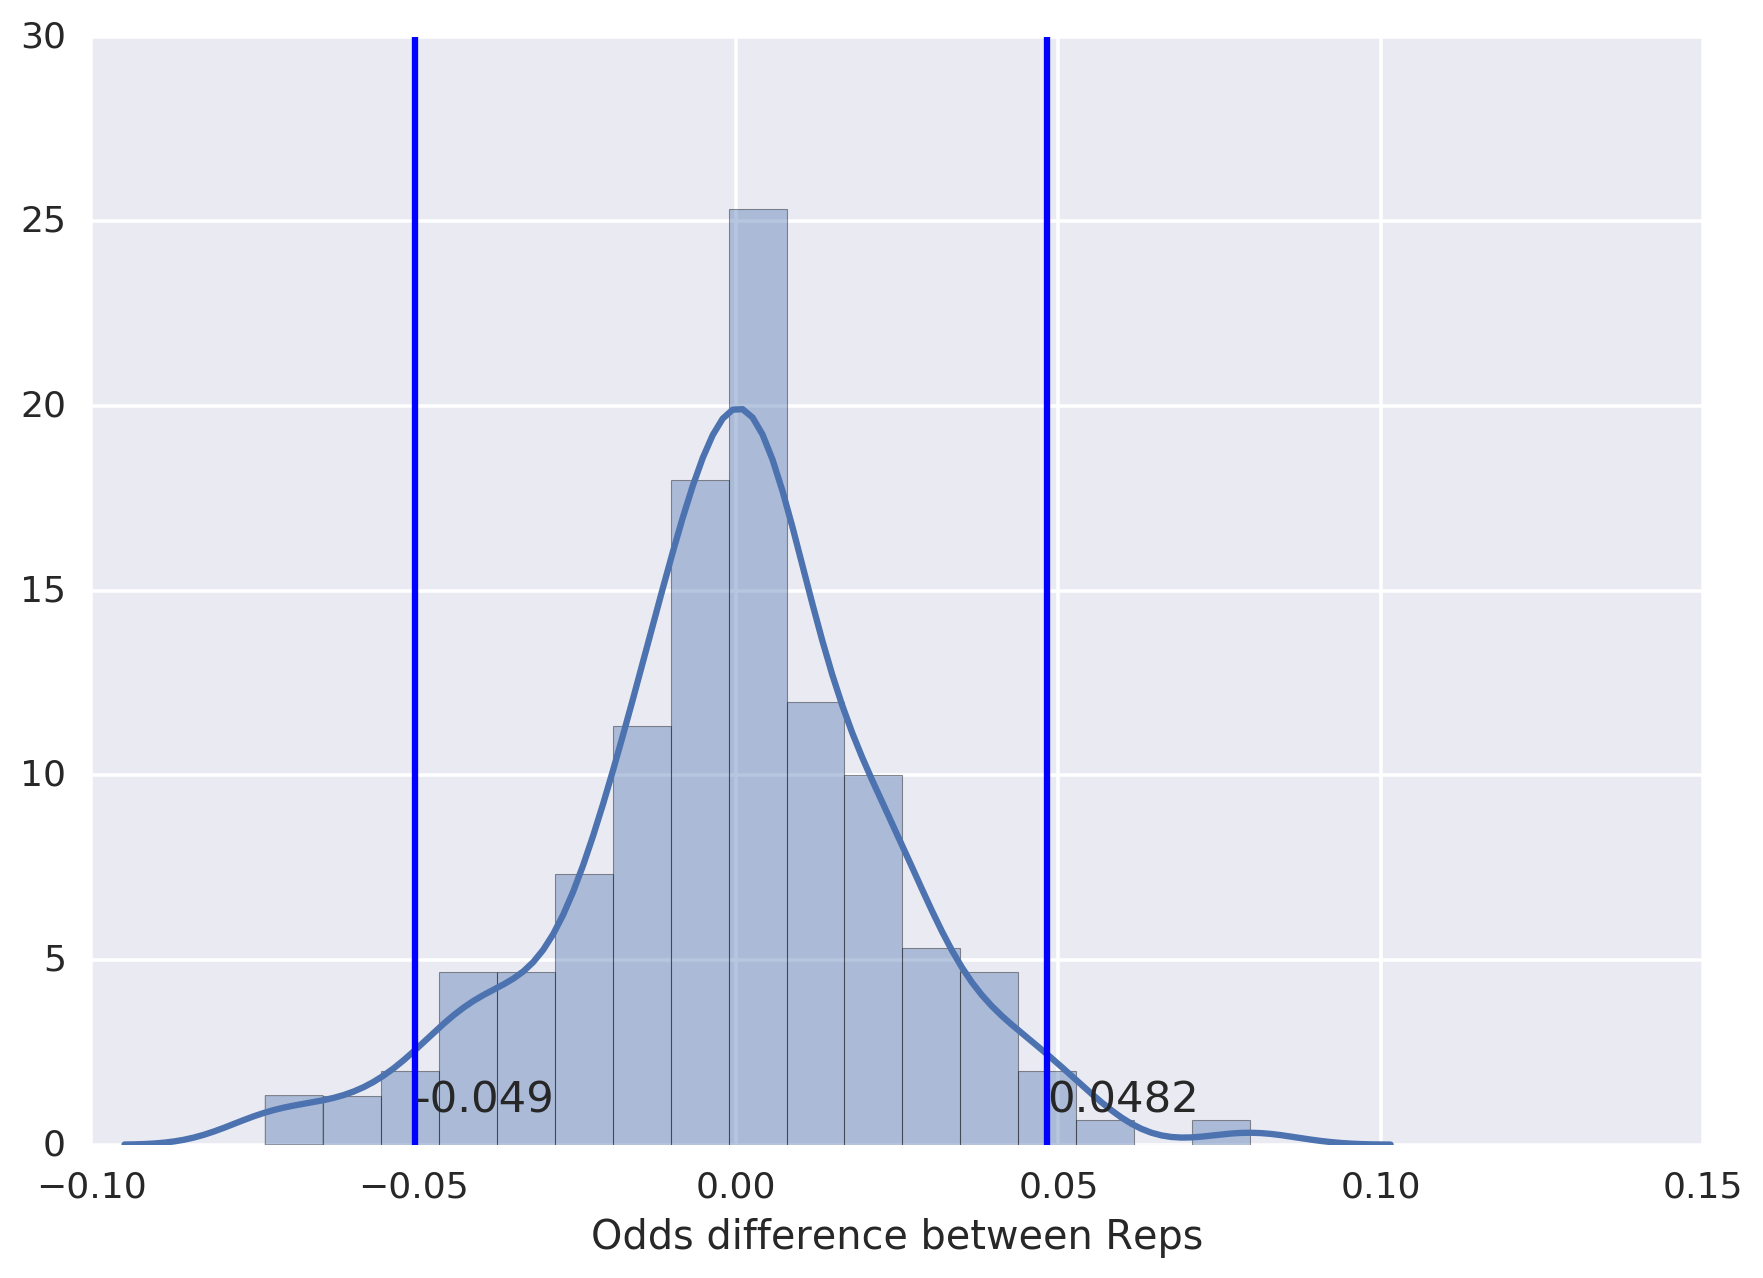

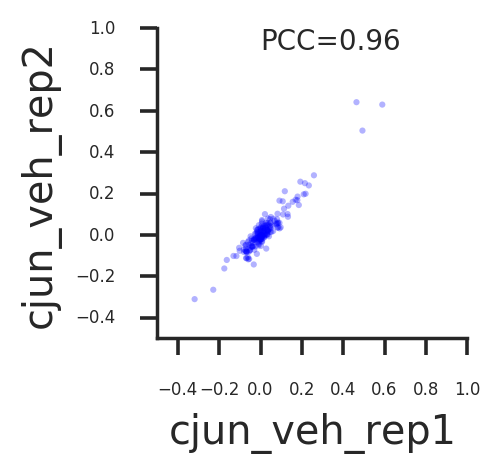

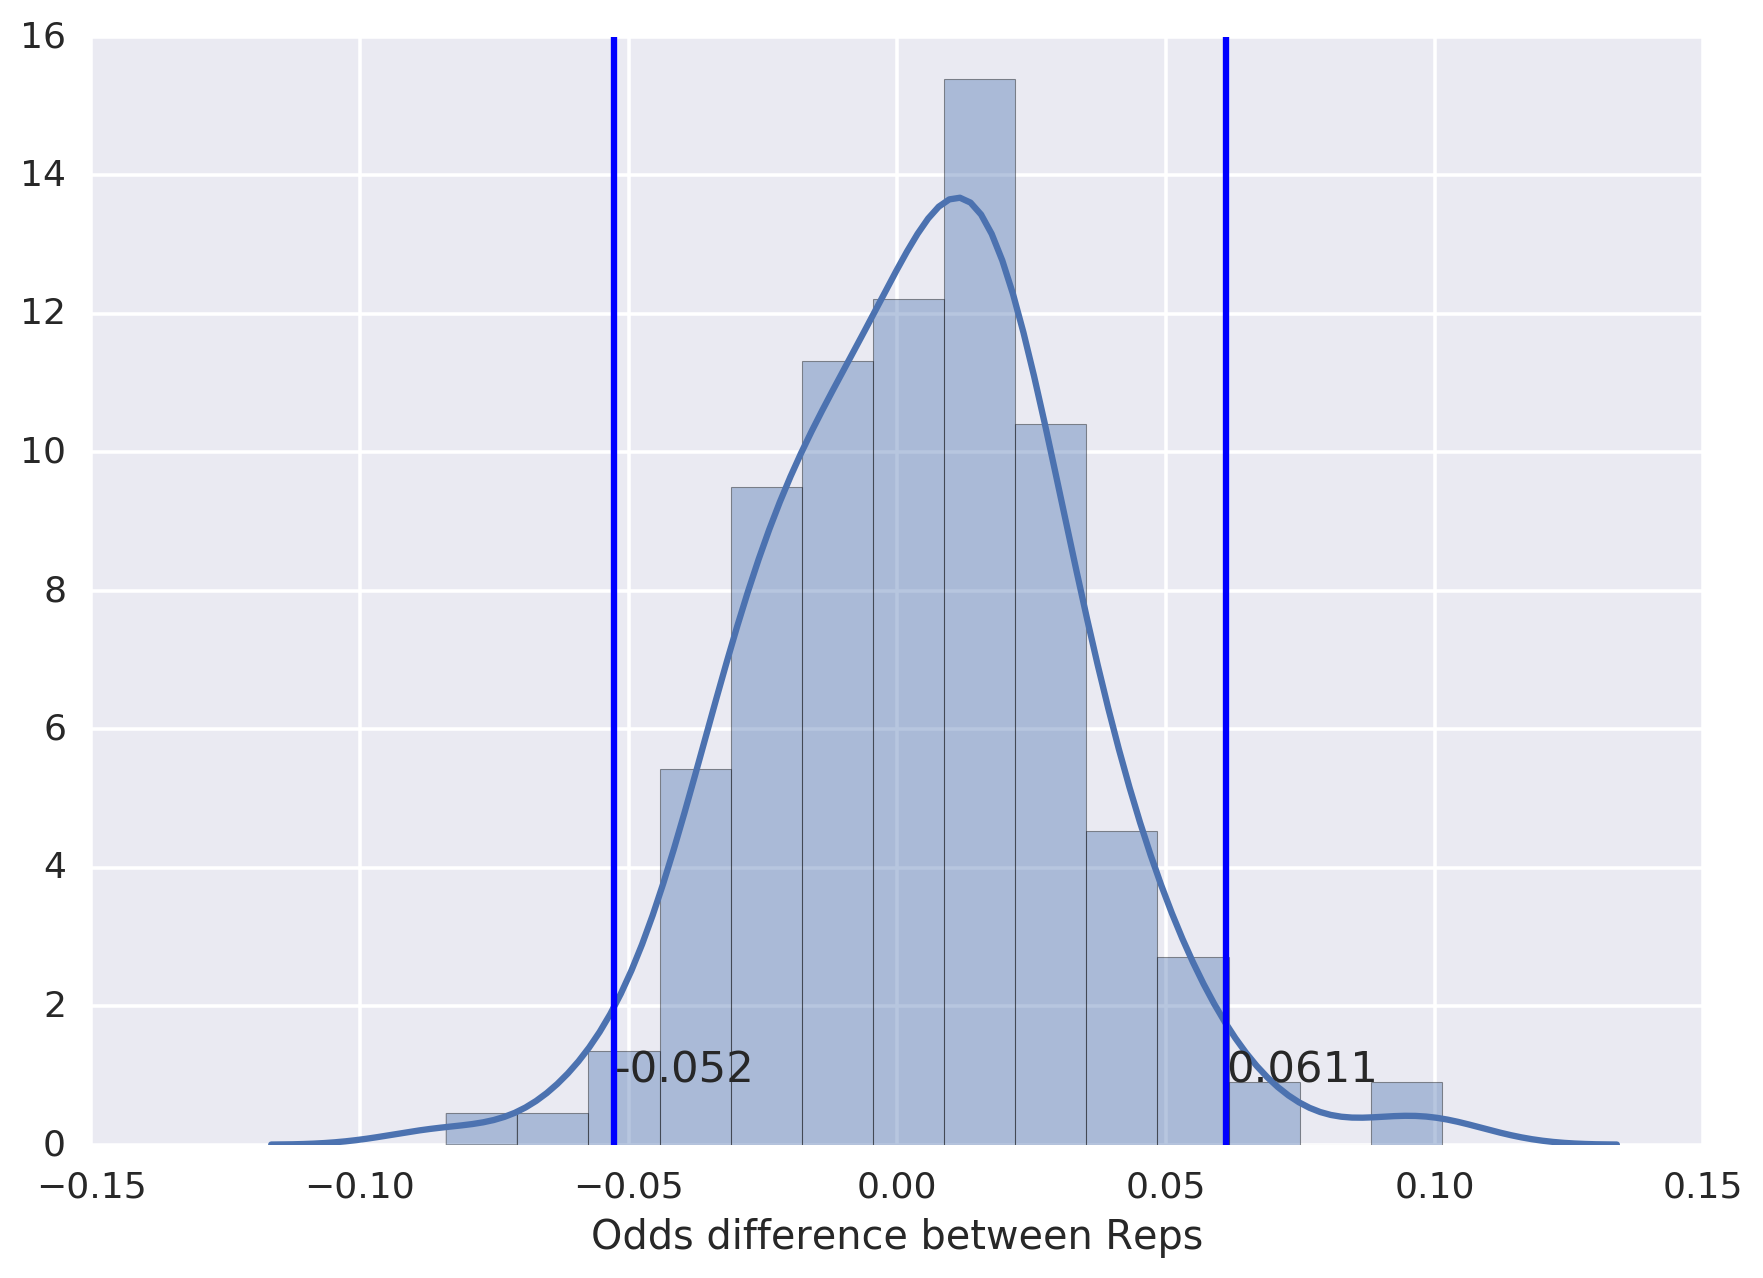

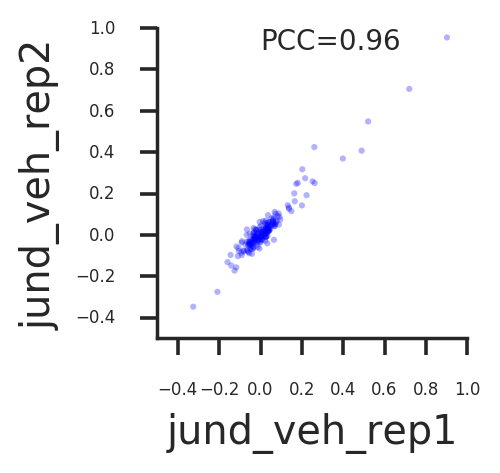

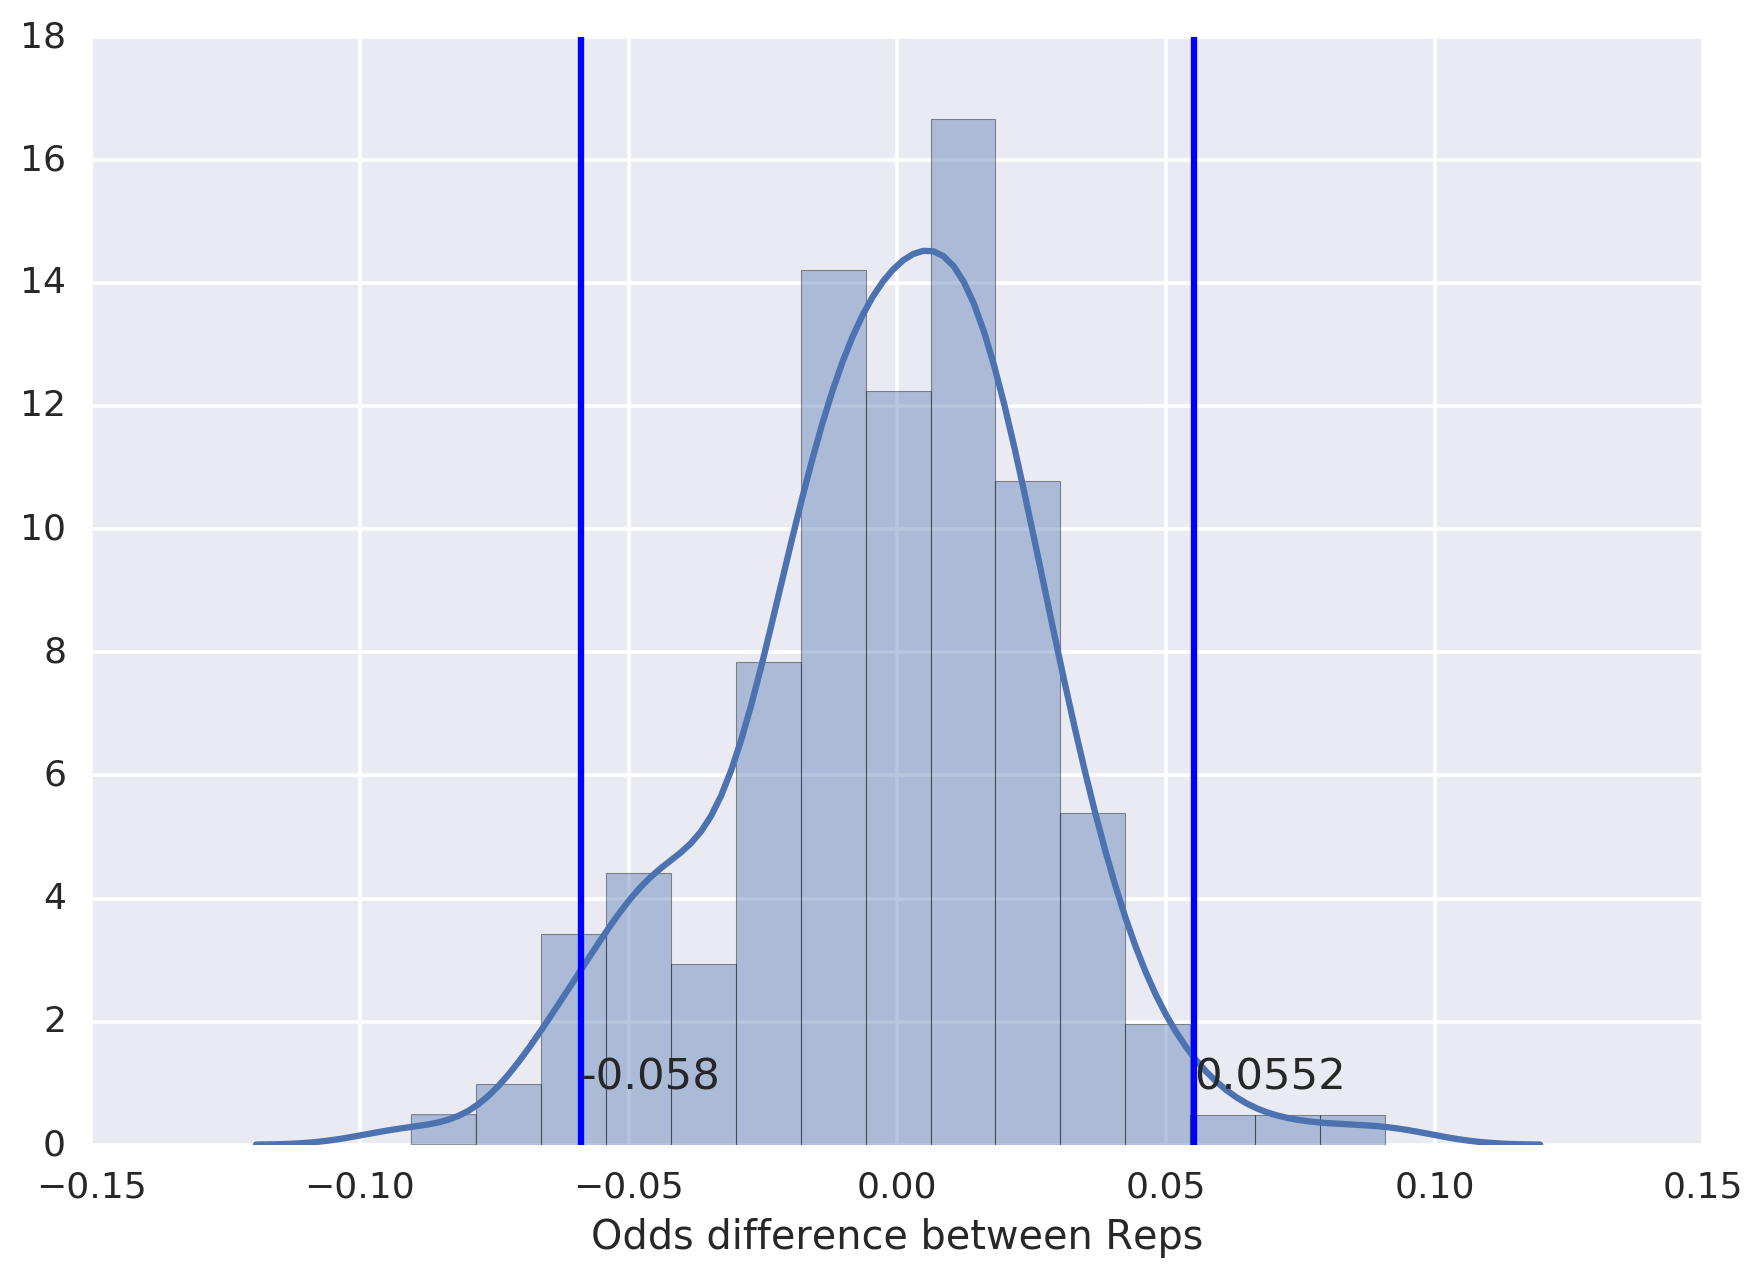

In [495]:
for treatment in ['veh']:
    for factor in ['atf3', 'cjun', 'jund']:
        rep1_label = '_'.join([factor, treatment, 'rep1'])
        rep2_label = '_'.join([factor, treatment, 'rep2'])
        idr_label = '_'.join([factor, treatment, 'idr'])
        
        rep1_weights = pd.Series(data=mean_weights_frame[rep1_label].values,
                                 index=mean_weights_frame.index.values)
        rep2_weights = pd.Series(data=mean_weights_frame[rep2_label].values,
                                 index=mean_weights_frame.index.values)
        
        idr_weights = pd.Series(data=mean_weights_frame[idr_label].values,
                                index=mean_weights_frame.index.values)
        
        rep_corr, pval = scipy.stats.pearsonr(rep1_weights, rep2_weights)
        rep1_corr, pval = scipy.stats.pearsonr(idr_weights, rep1_weights)
        rep2_corr, pval = scipy.stats.pearsonr(idr_weights, rep2_weights)
        
        with sns.axes_style('ticks'):
            plt.figure(figsize=(2,2))
#             plt.scatter(np.exp(rep1_weights),
#                         np.exp(rep2_weights),
#                         edgecolor='None', 
#                         s=5,
#                         alpha=0.3)
            plt.scatter(rep1_weights,
                        rep2_weights,
                        edgecolor='None', 
                        s=5,
                        alpha=0.3)
#             plt.annotate(xy=(1,2.5), s='PCC='+str(rep_corr)[:4], size=10)
#             plt.xlim(0.5, 3)
#             plt.ylim(0.5, 3)
            plt.annotate(xy=(0,0.9), s='PCC='+str(rep_corr)[:4], size=10)
            plt.xlim(-0.5, 1)
            plt.ylim(-0.5, 1)
            ax = plt.gca()
            ax.set_aspect(1.0)
            plt.xlabel(rep1_label)
            plt.ylabel(rep2_label)
            plt.tick_params(axis='both', which='major', labelsize=6)
            sns.despine()
            plt.show()
        small_weights = idr_weights[(np.exp(idr_weights) < 1.1)].index.values
#         odds_ratio_difference = pd.Series(np.exp(rep1_weights)-np.exp(rep2_weights), 
#                                           index = mean_weights_frame.index.values)
        odds_ratio_difference = pd.Series(np.exp(rep1_weights[rep1_weights.index.isin(small_weights)]) - \
                                          np.exp(rep2_weights[rep2_weights.index.isin(small_weights)]), 
                                          index = small_weights)
        sns.distplot(odds_ratio_difference)
        std_dev = np.std(odds_ratio_difference) * 2
        mean = np.mean(odds_ratio_difference)
        plt.axvline(x=mean - 1*std_dev, ymin=0, ymax=1)
        plt.axvline(x=mean + 1*std_dev, ymin=0, ymax=1)
        plt.annotate(xy=(mean-1*std_dev, 0.9), s=str(mean-1*std_dev)[:6])
        plt.annotate(xy=(mean+1*std_dev, 0.9), s=str(mean+1*std_dev)[:6])
        plt.xlabel('Odds difference between Reps')
        plt.show()
#         plt.scatter(np.exp(idr_weights), abs(odds_ratio_difference),
#                     edgecolor='None',
#                     s=5)
#         plt.xlabel('IDR motif odds ratio')
#         plt.ylabel('Odds Ratio between Reps')
#         plt.gca().set_aspect(1.0)
#         plt.show()
        
#         print(odds_ratio_difference)

In [496]:
# odds_ratios = mean_weights_frame.ix[:, ['atf3_veh_idr', 'cjun_veh_idr', 'jund_veh_idr']].apply(np.exp)
odds_ratios = mean_weights_frame.ix[:, ['atf3_veh_rep1', 'atf3_veh_rep2',
                                        'cjun_veh_rep1', 'cjun_veh_rep2',
                                        'jund_veh_rep1', 'jund_veh_rep2']]#.apply(np.exp)

In [497]:
# filtered_odds_ratios = odds_ratios[((odds_ratios-1).abs() >= 0.05).max(axis=1)]

In [498]:
filtered_odds_ratios = filtered_odds_ratios[~filtered_odds_ratios.index.isin(['pparg', 'pparg_rxra'])]

In [517]:
mean_weights_frame.ix[:, ['atf3_veh_rep1', 'atf3_veh_rep2', 'atf3_veh_idr',
                                              'cjun_veh_rep1', 'cjun_veh_rep2', 'cjun_veh_idr',
                                              'jund_veh_rep1', 'jund_veh_rep2', 'jund_veh_idr'
                                             ]].rank()

atf3_veh_rep1  atf3_veh_rep2  atf3_veh_idr  cjun_veh_rep1  \
alx1_alx4_arx             106.0           95.0         136.0           63.0   
ap-1                      196.0          196.0         196.0          196.0   
ar_nr3c1_nr3c2            113.0          118.0         109.0          116.0   
arid3a                     11.0            9.0          30.0           24.0   
arid3b                     24.0           27.0          17.0            7.0   
arid5a                     46.0           61.0          53.0           89.0   
arnt_mycn                 111.0          105.0         130.0           52.0   
arntl_mitf                171.0          165.0         178.0          174.0   
ascl2_nhlh1               168.0          168.0         167.0          143.0   
atf7_batf3_creb5          193.0          193.0         193.0          194.0   
bcl6                       52.0          121.0          89.0           85.0   
bcl6b                      94.0           74.0          55.0           79.0   
bhlh                       74.0           91.0         149.0           67.0   
bhlha15                    81.0           70.0          41.0           75.0   
bhlhe23                    78.0           42.0          49.0           54.0   
cdx                        38.0           93.0          31.0          130.0   
cebp                      195.0          195.0         195.0          193.0   
cenpb                     152.0          149.0         131.0          161.0   
creb3-l1                  114.0           65.0          85.0           90.0   
crem                      105.0          153.0         155.0          155.0   
ctcf                      185.0          180.0         172.0          181.0   
cux                        80.0           56.0          37.0           47.0   
dbp_hlf_tef               191.0          191.0         190.0          171.0   
dmbx1                     128.0          103.0          90.0          102.0   
dmrt3                      71.0           51.0          56.0           83.0   
dux                       145.0          157.0         128.0          148.0   
dux4                       98.0           90.0         111.0          107.0   
duxa                      176.0          164.0         169.0           62.0   
e2f1                      138.0          125.0          97.0          108.0   
e2f2                       93.0          119.0         106.0           94.0   
...                         ...            ...           ...            ...   
tbx                       141.0          154.0         100.0          157.0   
tcf21                     161.0          148.0         157.0          145.0   
tcf7                      110.0          117.0         122.0          149.0   
tcfl5                     189.0          186.0         180.0          178.0   
tead                       26.0           10.0          28.0           19.0   
tfap1                     116.0          109.0         127.0          134.0   
tfap2-3                    65.0           64.0          86.0           92.0   
tfcp2                     148.0          169.0         161.0          163.0   
thap1                     170.0          170.0         154.0          150.0   
tp53                       69.0           96.0          93.0          114.0   
tp63                      107.0          130.0         144.0          117.0   
tp73                      142.0           53.0          75.0           51.0   
usf                       172.0          175.0         176.0          180.0   
ventx                      22.0           30.0          22.0           40.0   
xbp1                      177.0          178.0         175.0          177.0   
yy1                         4.0            3.0           3.0            3.0   
yy2                        39.0           66.0          43.0           44.0   
zbed1                     149.0          142.0         150.0          131.0   
zbtb18                    126.0          140.0         158.0        

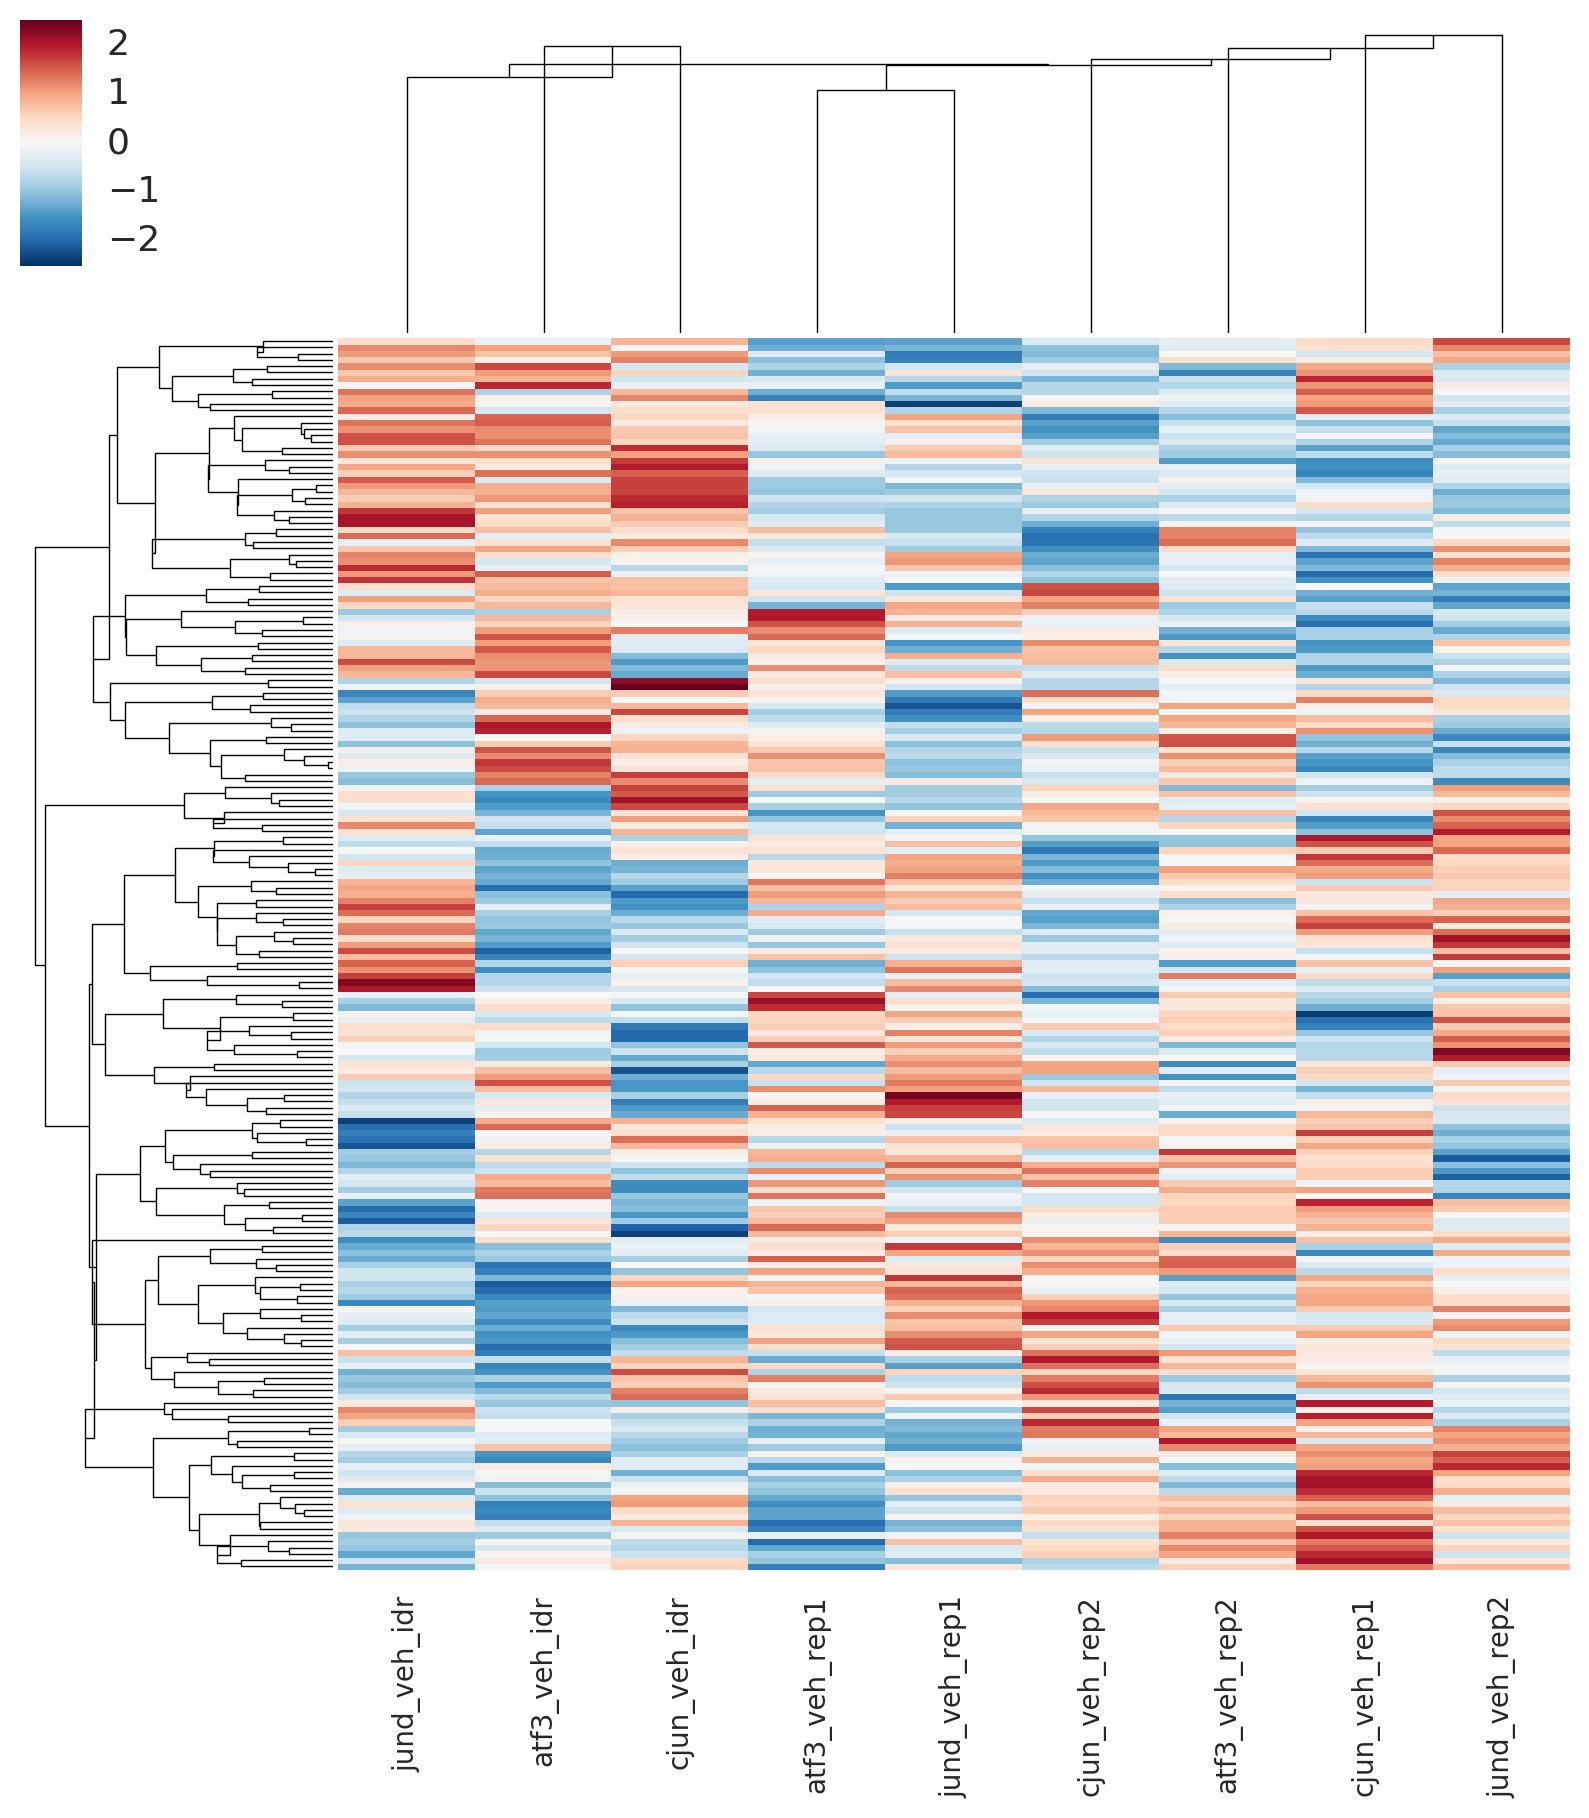

In [527]:
# cm = sns.clustermap(filtered_odds_ratios[((filtered_odds_ratios.max(axis=1) - filtered_odds_ratios.min(axis=1)) > 0.05) &
#                                           (filtered_odds_ratios.max(axis=1) < np.exp(0.5) )
#                                           ],
# #                     col_cluster = False,
#                     metric = 'correlation',
#                     z_score=0)
cm = sns.clustermap(mean_weights_frame.ix[:, ['atf3_veh_rep1', 'atf3_veh_rep2', 'atf3_veh_idr',
                                              'cjun_veh_rep1', 'cjun_veh_rep2', 'cjun_veh_idr',
                                              'jund_veh_rep1', 'jund_veh_rep2', 'jund_veh_idr'
                                             ]], 
                    metric='correlation', 
                    z_score=0,
                    method = 'centroid',
                    yticklabels=False,
#                     vmin = -2.5,
#                     vmax = 2.5
                   )
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), 
         fontsize=7, 
         rotation=0);
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=90);

In [505]:
# filtered_odds_ratios.ix['nr2f1']

In [418]:
# mean_weights_frame.ix[['ap-1', 'cebp', 'nr2f1', 'spi1-c', 'pparg'], 
#                       ['cjun_veh_rep1', 'cjun_veh_rep2', 'cjun_veh_idr', 
#                        'atf3_veh_rep1', 'atf3_veh_rep2', 'atf3_veh_idr',
#                        'jund_veh_rep1', 'jund_veh_rep2', 'jund_veh_idr']]